In [1]:
import pandas as pd
import numpy as np
import sys,os
import matplotlib.pyplot as plt
import utils
import concurrent.futures
import importlib

In [2]:

# CIFAR ICML experiments
target_dir = "my_results/icml_experiments/cifar10/"
ATTACK_RESULTS_PATH = "my_results/icml_experiments/cifar10_attack_results_unbalanced/"

# Tryouts for Femnist
# target_dir = "my_results/test/testing_femnist_convergence_rates/"
# ATTACK_RESULTS_PATH = "my_results/test/femnist_attack_results/"

#Tryouts for CIFAR
# target_dir = "my_results/test/testing_convergence_rates/"
# ATTACK_RESULTS_PATH = "my_results/test/femnist_attack_results/"

TOTAL_PROCESSES = 128
MAX_MACHINES =  8
MAX_ITERATIONS=10000
STARTING_ITERATION = 0

linestyles = {
    "ZeroSum" : "--"
}

fontsize=20

alpha = 0.1

save_directory = "assets/"



assert TOTAL_PROCESSES%MAX_MACHINES == 0
MAX_PROCESSES = TOTAL_PROCESSES//MAX_MACHINES

In [3]:
# Load the file list
experiments_dict = utils.get_full_path_dict(target_dir)
experiments_attributes = utils.get_experiments_dict(experiments_dict)

print(experiments_dict)

{'2069890_muffliato_static_128nodes_10avgsteps_32th': 'my_results/icml_experiments/cifar10/2069890_muffliato_static_128nodes_10avgsteps_32th', '2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th': 'my_results/icml_experiments/cifar10/2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th', '2079616_muffliato_static_128nodes_1avgsteps_2th': 'my_results/icml_experiments/cifar10/2079616_muffliato_static_128nodes_1avgsteps_2th', '2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th': 'my_results/icml_experiments/cifar10/2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th', '2079628_muffliato_static_128nodes_1avgsteps_32th': 'my_results/icml_experiments/cifar10/2079628_muffliato_static_128nodes_1avgsteps_32th', '2068761_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_16th': 'my_results/icml_experiments/cifar10/2068761_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_16th', '2069889_muffliato_static_128nodes_10avgsteps_16th': 'my_results/icml_experiments/cifar10/2069889_muffliato

In [4]:
machine_folder = 'machine{}'
result_file = '{}_results.json'


def load_data(dir):
    data = pd.DataFrame({})
    for machine in range(MAX_MACHINES):
        for rank in range(MAX_PROCESSES):
            # print(f"Loading results for machine {machine} and rank {rank}.  ",end = "\r")
            uid = rank + machine * MAX_PROCESSES

            file = os.path.join(dir, machine_folder.format(machine), result_file.format(rank))
            tmp_df = pd.read_json(file)
            tmp_df["uid"] = uid # Manually add the uid for further processing                                                                   
            tmp_df["iteration"] = tmp_df.index
            # print(tmp_df)
            tmp_df = tmp_df[tmp_df["iteration"]>=STARTING_ITERATION]
            tmp_df = tmp_df[tmp_df["iteration"]<=MAX_ITERATIONS]
            data = pd.concat([data,tmp_df])
    return data




def load_attack_results(current_experiment_data,experiment_name,attack_results_path):
    expected_file_name = experiment_name + ".csv"
    directories = sorted(os.listdir(attack_results_path))
    
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {attack_results_path}. Entire directory:\n{directories}")
        return current_experiment_data
    attacks_df = pd.read_csv(os.path.join(attack_results_path,expected_file_name))
    attacks_df = attacks_df.drop(columns = "Unnamed: 0")
    attacks_df = attacks_df.rename(columns = {"agent":"uid"})
    # print(attacks_df.columns)
    # print(current_experiment_data)
    # print(attacks_df)
    
    res = pd.merge(current_experiment_data, attacks_df,on = ["uid","iteration"],how="outer" )
    # print(res)
    return res

def load_linkability_attack_results(current_experiment_data,experiment_name,attack_results_path):
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(attack_results_path))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {attack_results_path}. Entire directory:\n{directories}")
        return current_experiment_data
    
    linkability_attack_df = pd.read_csv(os.path.join(attack_results_path,expected_file_name))

    linkability_attack_df = linkability_attack_df.rename(columns = {"agent":"uid"})

    return pd.merge(current_experiment_data,linkability_attack_df,on = ["uid","iteration"],how="outer")

# Function to recompute some of the linkability attack results. Should only be used if there are errors in the data (see perform_attack.py).
def fix_linkability_attack_results(experiment_name,attack_results_path):
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(attack_results_path))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {attack_results_path}. Entire directory:\n{directories}")
        raise FileNotFoundError(expected_file_name)
    
    linkability_attack_df = pd.read_csv(os.path.join(attack_results_path,expected_file_name))
    
    # Fixing all the missing values/wrongly filled values  
    linkability_attack_df["linkability_top1"] = (linkability_attack_df["linkability_top1_guess"]==linkability_attack_df["agent"])
    
    linkability_attack_df.reset_index(drop = True)
    linkability_attack_df.set_index(["agent","iteration"])
    columns = linkability_attack_df.columns.to_list()
    columns_losses = [column for column in columns if "loss_trainset_" in column]
    
    linkability_attack_df["linkability_real_rank"] = np.nan
    linkability_attack_df["linkability_real_rank"].astype('Int64',copy=False)
    for index,row in linkability_attack_df.iterrows():
        losses = [(int(column.split("_")[2]),row[column]) for column in columns_losses]
        losses_sorted = sorted(losses, key = lambda x:x[1])
        agents_sorted = [x[0] for x in losses_sorted]
        current_agent = row["agent"]
        linkability_rank = agents_sorted.index(current_agent)
        linkability_attack_df.at[index,"linkability_real_rank"] = linkability_rank
    
    linkability_attack_df = linkability_attack_df.drop(columns = "Unnamed: 0")
    linkability_attack_df.to_csv(os.path.join(attack_results_path,f"fixed_{expected_file_name}"))
    
    return linkability_attack_df

def load_data_element(input_dict,name,filepath,attack_result_path):
    print(f"Loading data from {name}")
    current_results = load_data(filepath).dropna()
    current_results = load_attack_results(current_results,name,attack_results_path=attack_result_path)
    input_dict[name] = load_linkability_attack_results(current_results,name,attack_results_path=attack_result_path)
    # input_dict[name] = current_results
    print(f"Finished loading data from {name}")
    return



loaded_data = {}

with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    for name,filepath in sorted(experiments_dict.items()):
        executor.submit(load_data_element,loaded_data,name,filepath,ATTACK_RESULTS_PATH)
        
        # load_data_element(loaded_data,name,filepath,ATTACK_RESULTS_PATH)
        # break
        
        # fix_linkability_attack_results(name,attack_results_path=ATTACK_RESULTS_PATH)
        # break
# print(loaded_data)
print("Finished loading all data")

Loading data from 2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
Loading data from 2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
Loading data from 2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
Loading data from 2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
Loading data from 2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
Loading data from 2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
Loading data from 2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
Loading data from 2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
Loading data from 2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
Loading data from 2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
Loading data from 2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
Loading data from 2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
Loading data from 2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
Loading 

In [5]:
general_agg_methods = ["mean", "std", "sum","min","max"]
columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n", "roc_auc"]
# columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n"]


def count_percentage_success(column:pd.Series):
    counts = column.value_counts(normalize=True)
    if True not in counts:
        return np.nan
    # print(counts.index)
    # print(counts[True])
    res = counts[True]
    return res 

linkability_aggregators = {
    "linkability_top1": [count_percentage_success],
    "linkability_real_rank": ["median","min","max"],
}


general_aggregator = {column:general_agg_methods for column in columns_to_agg}

general_aggregator.update(linkability_aggregators) 

def format_data(data,key):
    usable_data = data[["iteration"] + columns_to_agg +  list(linkability_aggregators.keys())]
    grouped_data = usable_data.groupby(['iteration']) 
    usable_data = grouped_data.agg(general_aggregator)
    usable_data.reset_index(inplace=True)
    usable_data.set_index("iteration",inplace=True)

    print(usable_data["linkability_top1"].dropna())

    usable_data.insert(1,"experience_name",key)
    usable_data.insert(2,"number_agents",TOTAL_PROCESSES)

    usable_data.columns = [' '.join(e) if len(e[-1])>0 else e[0] for e in usable_data.columns]

    
    
    experiment_attributes = utils.get_attributes(key)
    for attribute, attribute_value in experiment_attributes.items():
        usable_data[attribute] = attribute_value
    return usable_data



formatted_data = {}
for name,data in sorted(loaded_data.items()):
    print(f"Formatting {name}")
    formatted_data[name] = format_data(data,name)
formatted_data[list(formatted_data)[0]].columns

Formatting 2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
           count_percentage_success
iteration                          
500                        0.296875
1000                       0.320312
1500                       0.406250
2000                       0.468750
2500                       0.500000
3000                       0.617188
3500                       0.601562
4000                       0.710938
4500                       0.718750
5000                       0.804688
5500                       0.835938
6000                       0.914062
6500                       0.906250
7000                       0.929688
7500                       0.843750
8000                       0.796875
8500                       0.851562
9000                       0.921875
9500                       0.820312
10000                      0.937500
Formatting 2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
           count_percentage_success
iteration          

Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'roc_auc min',
       'roc_auc max', 'linkability_top1 count_percentage_success',
       'linkability_real_rank median', 'linkability_real_rank min',
       'linkability_real_rank max', 'network_size', 'topology_type', 'variant',
       'avgsteps', 'additional_attribute', 'noise_le

Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'roc_auc min',
       'roc_auc max', 'linkability_top1 count_percentage_success',
       'linkability_real_rank median', 'linkability_real_rank min',
       'linkability_real_rank max', 'network_size', 'topology_type', 'variant',
       'avgsteps', 'additional_attribute', 'noise_le

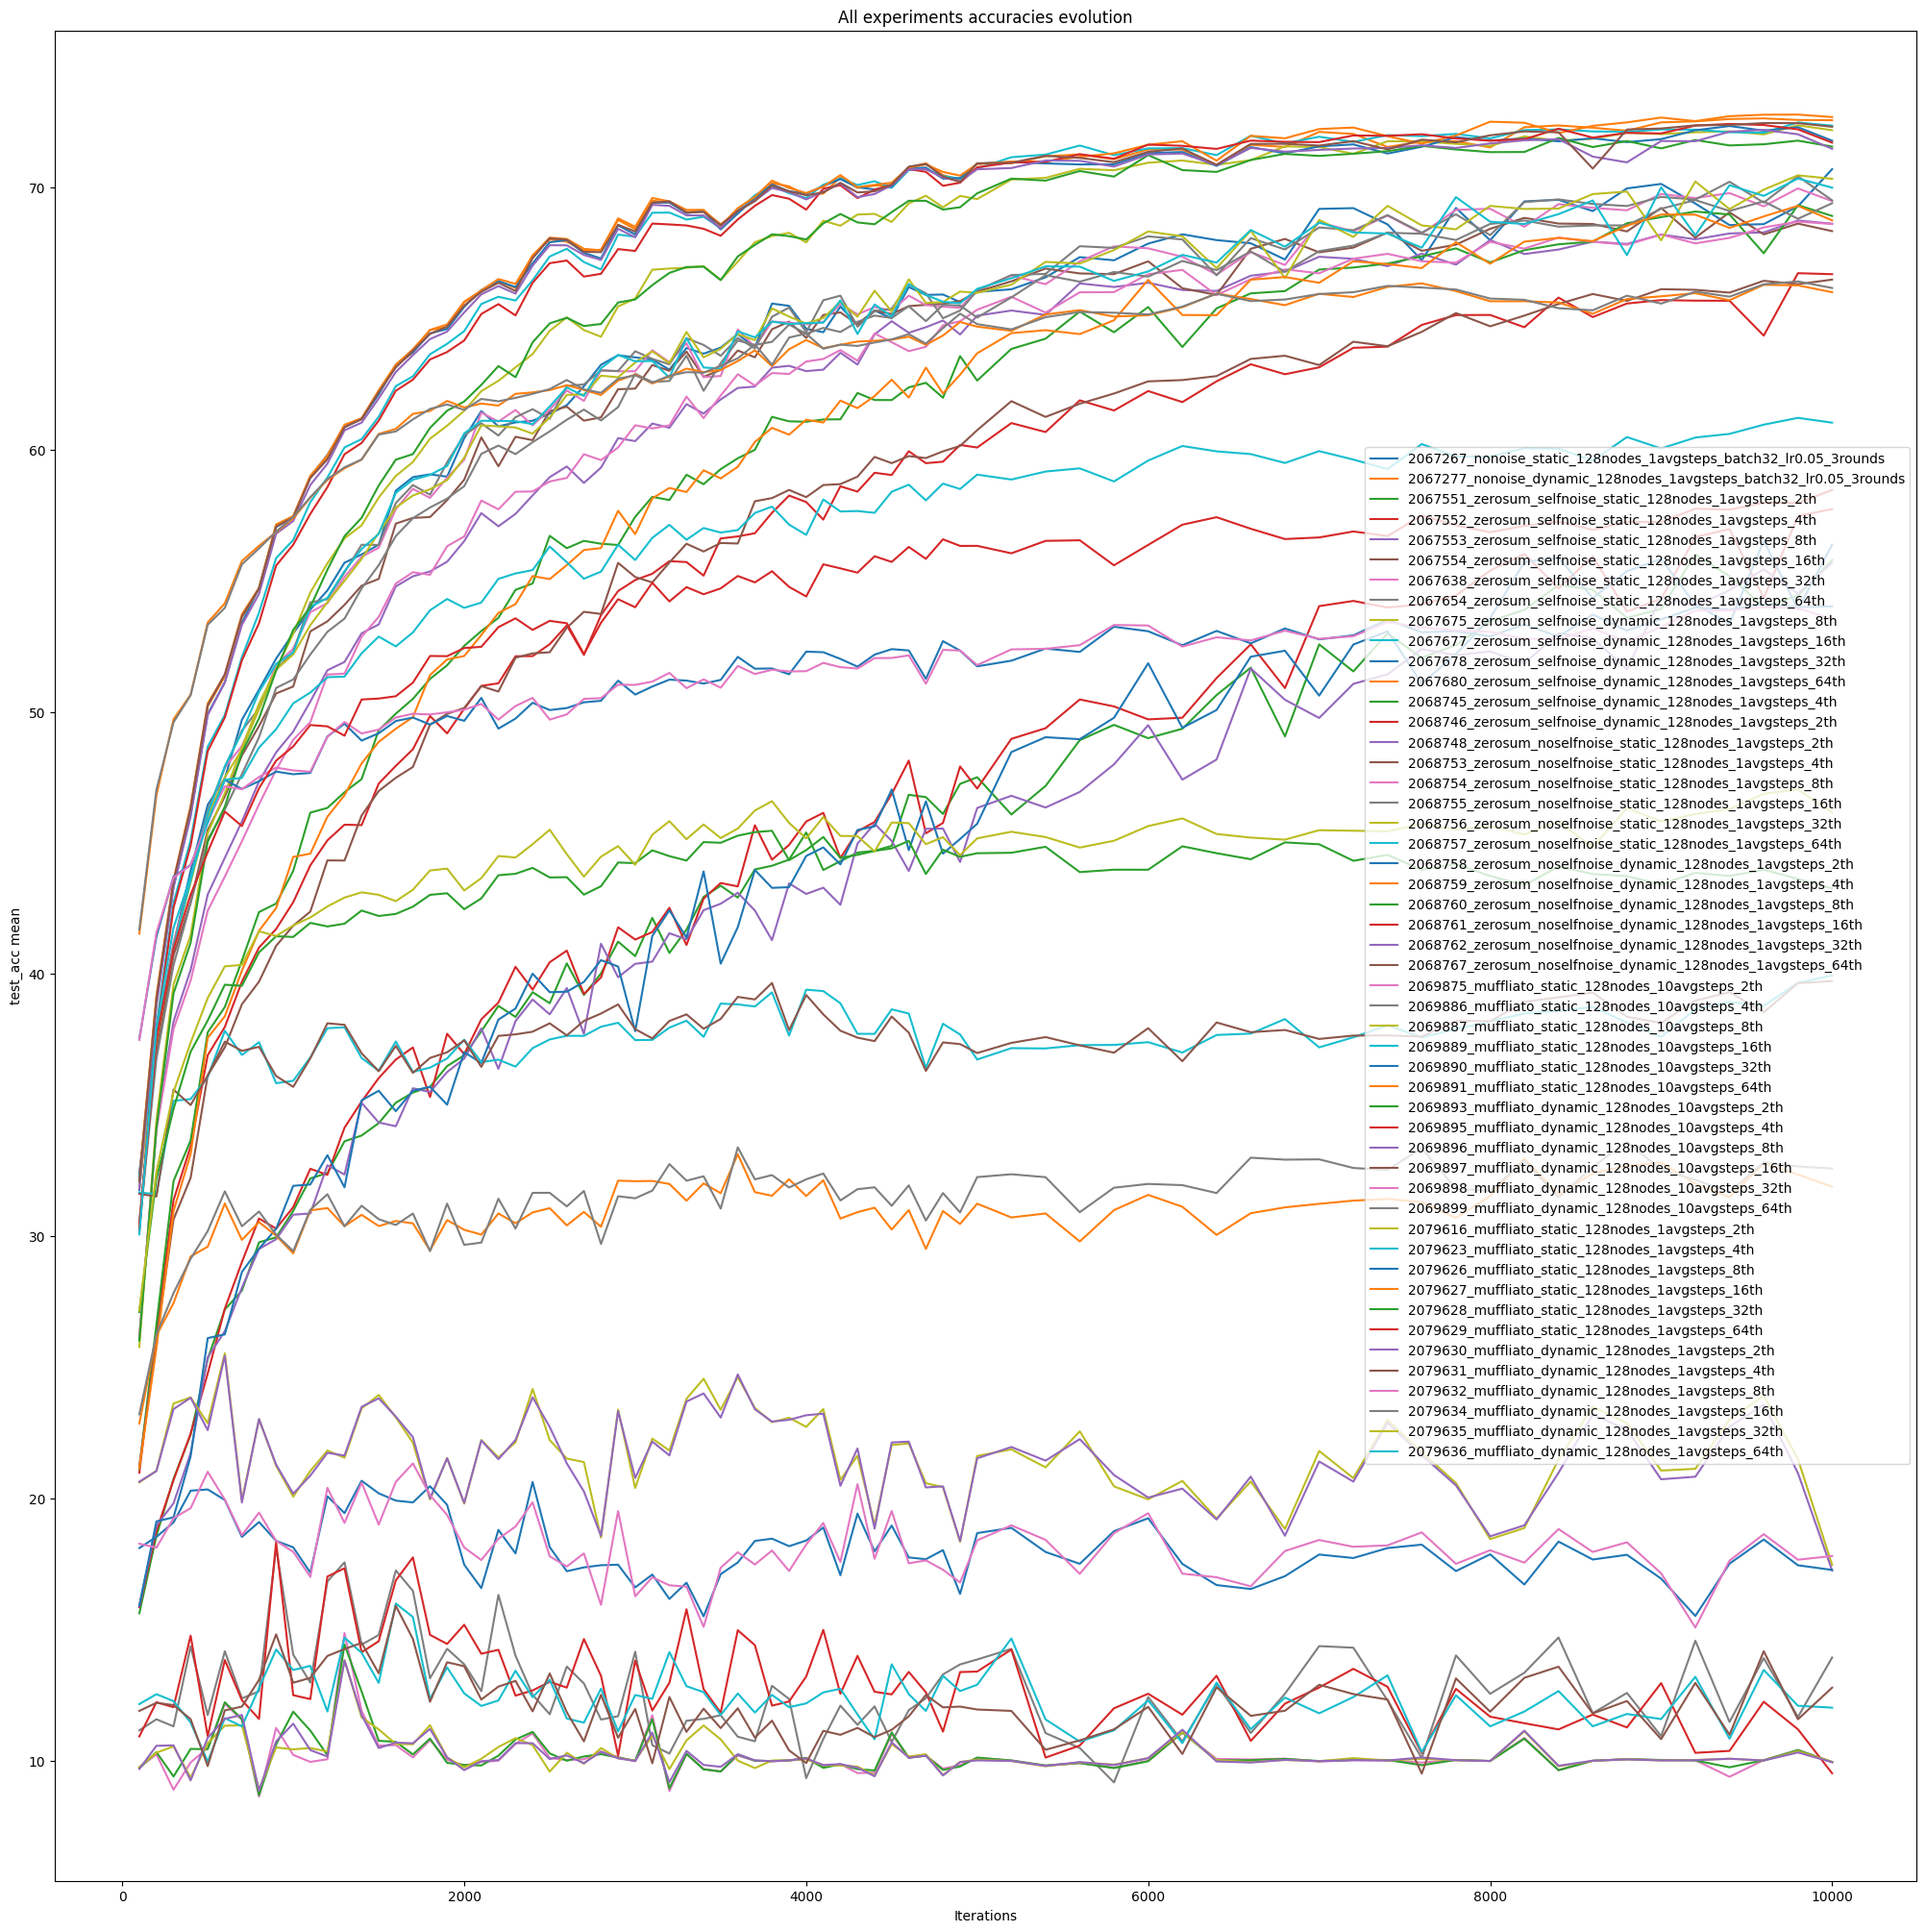

In [6]:
importlib.reload(utils)
utils.plot_all_experiments(
    formatted_data,
    experiments_attributes,
    experiments_attributes,
    None,
    "All experiments accuracies evolution",
    "test_acc mean",
    save_directory=save_directory
    
)


## Noise cancellation vs no noise cancellation

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2068748_zerosum_noselfnoise_static_128nodes_1avgsteps_2th
2068753_zerosum_noselfnoise_static_128nodes_1avgsteps_4th
2068754_zerosum_noselfnoise_static_128nodes_1avgsteps_8th
2068755_zerosum_noselfnoise_static_128nodes_1avgsteps_16th
2068756_zerosum_noselfnoise_static_128nodes_1avgsteps_32th
2068757_zerosum_noselfnoise_static_128nodes_1avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'tes

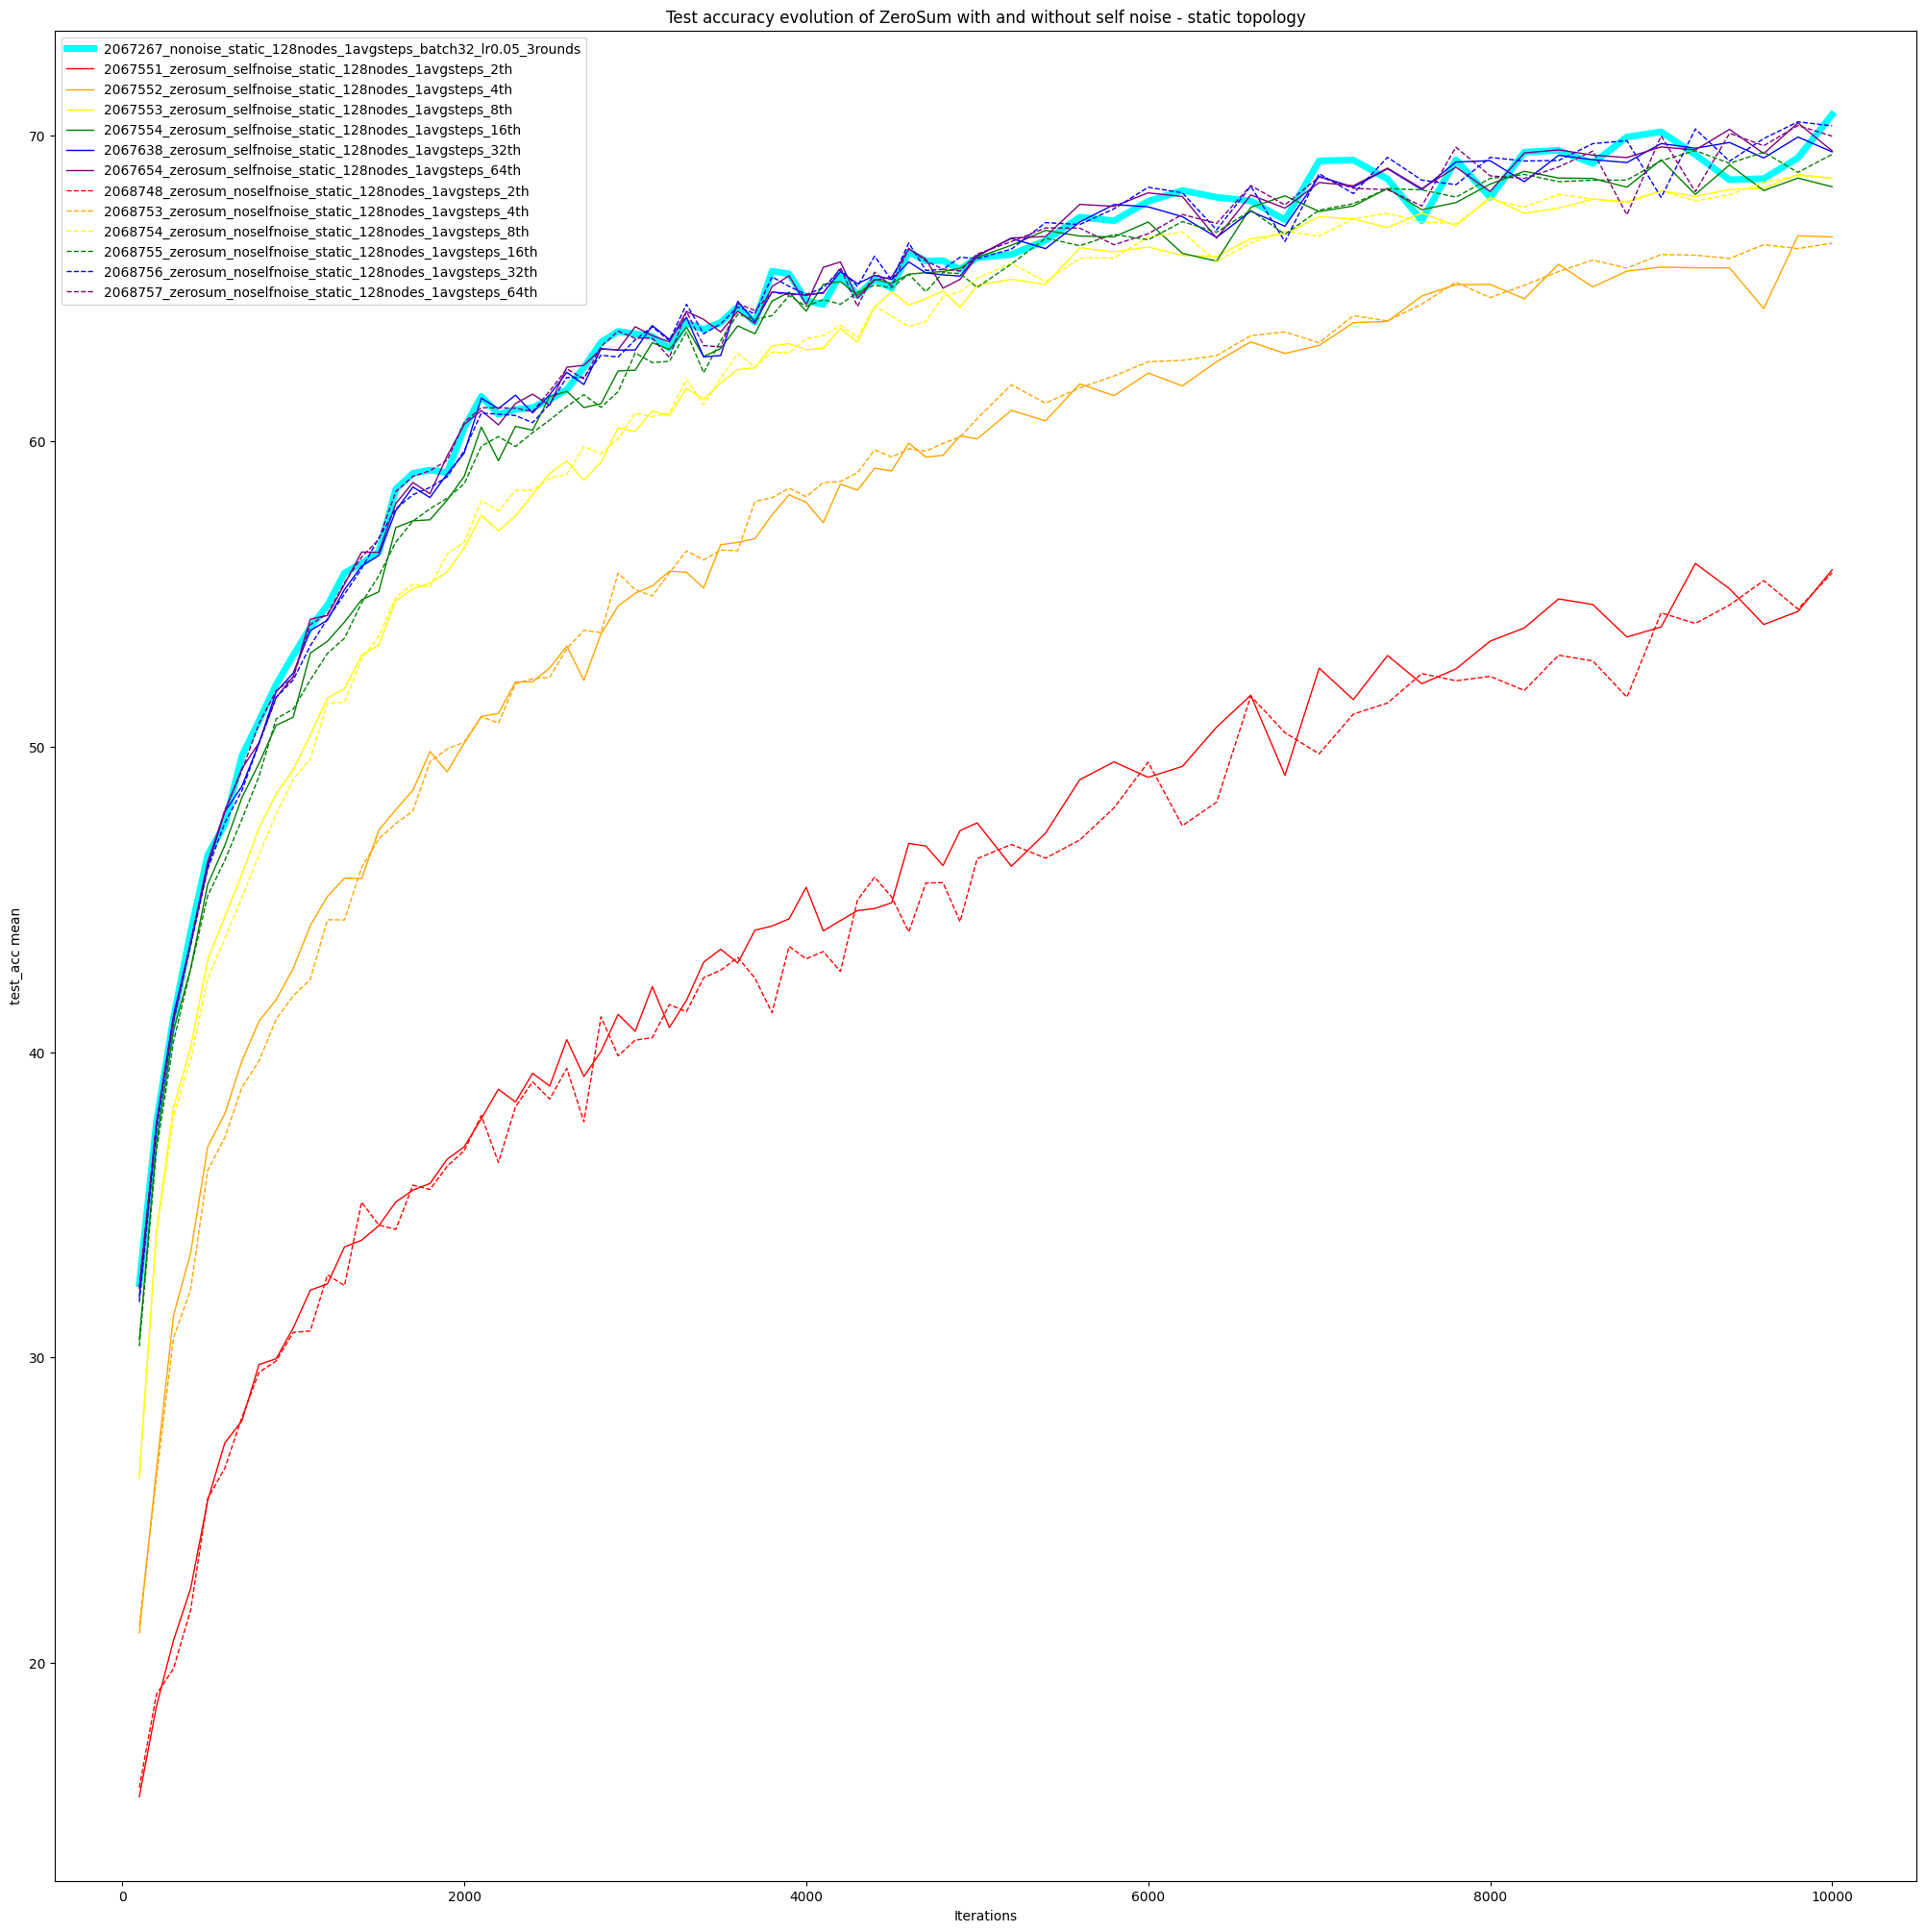

In [7]:
importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "noselfnoise":"--",
        "selfnoise":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Test accuracy evolution of ZeroSum with and without self noise - static topology",
    "test_acc mean",
    save_directory=save_directory
    
)



### In the dynamic case:

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2068758_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_2th
2068759_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_4th
2068760_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_8th
2068761_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_16th
2068762_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_32th
2068767_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max'

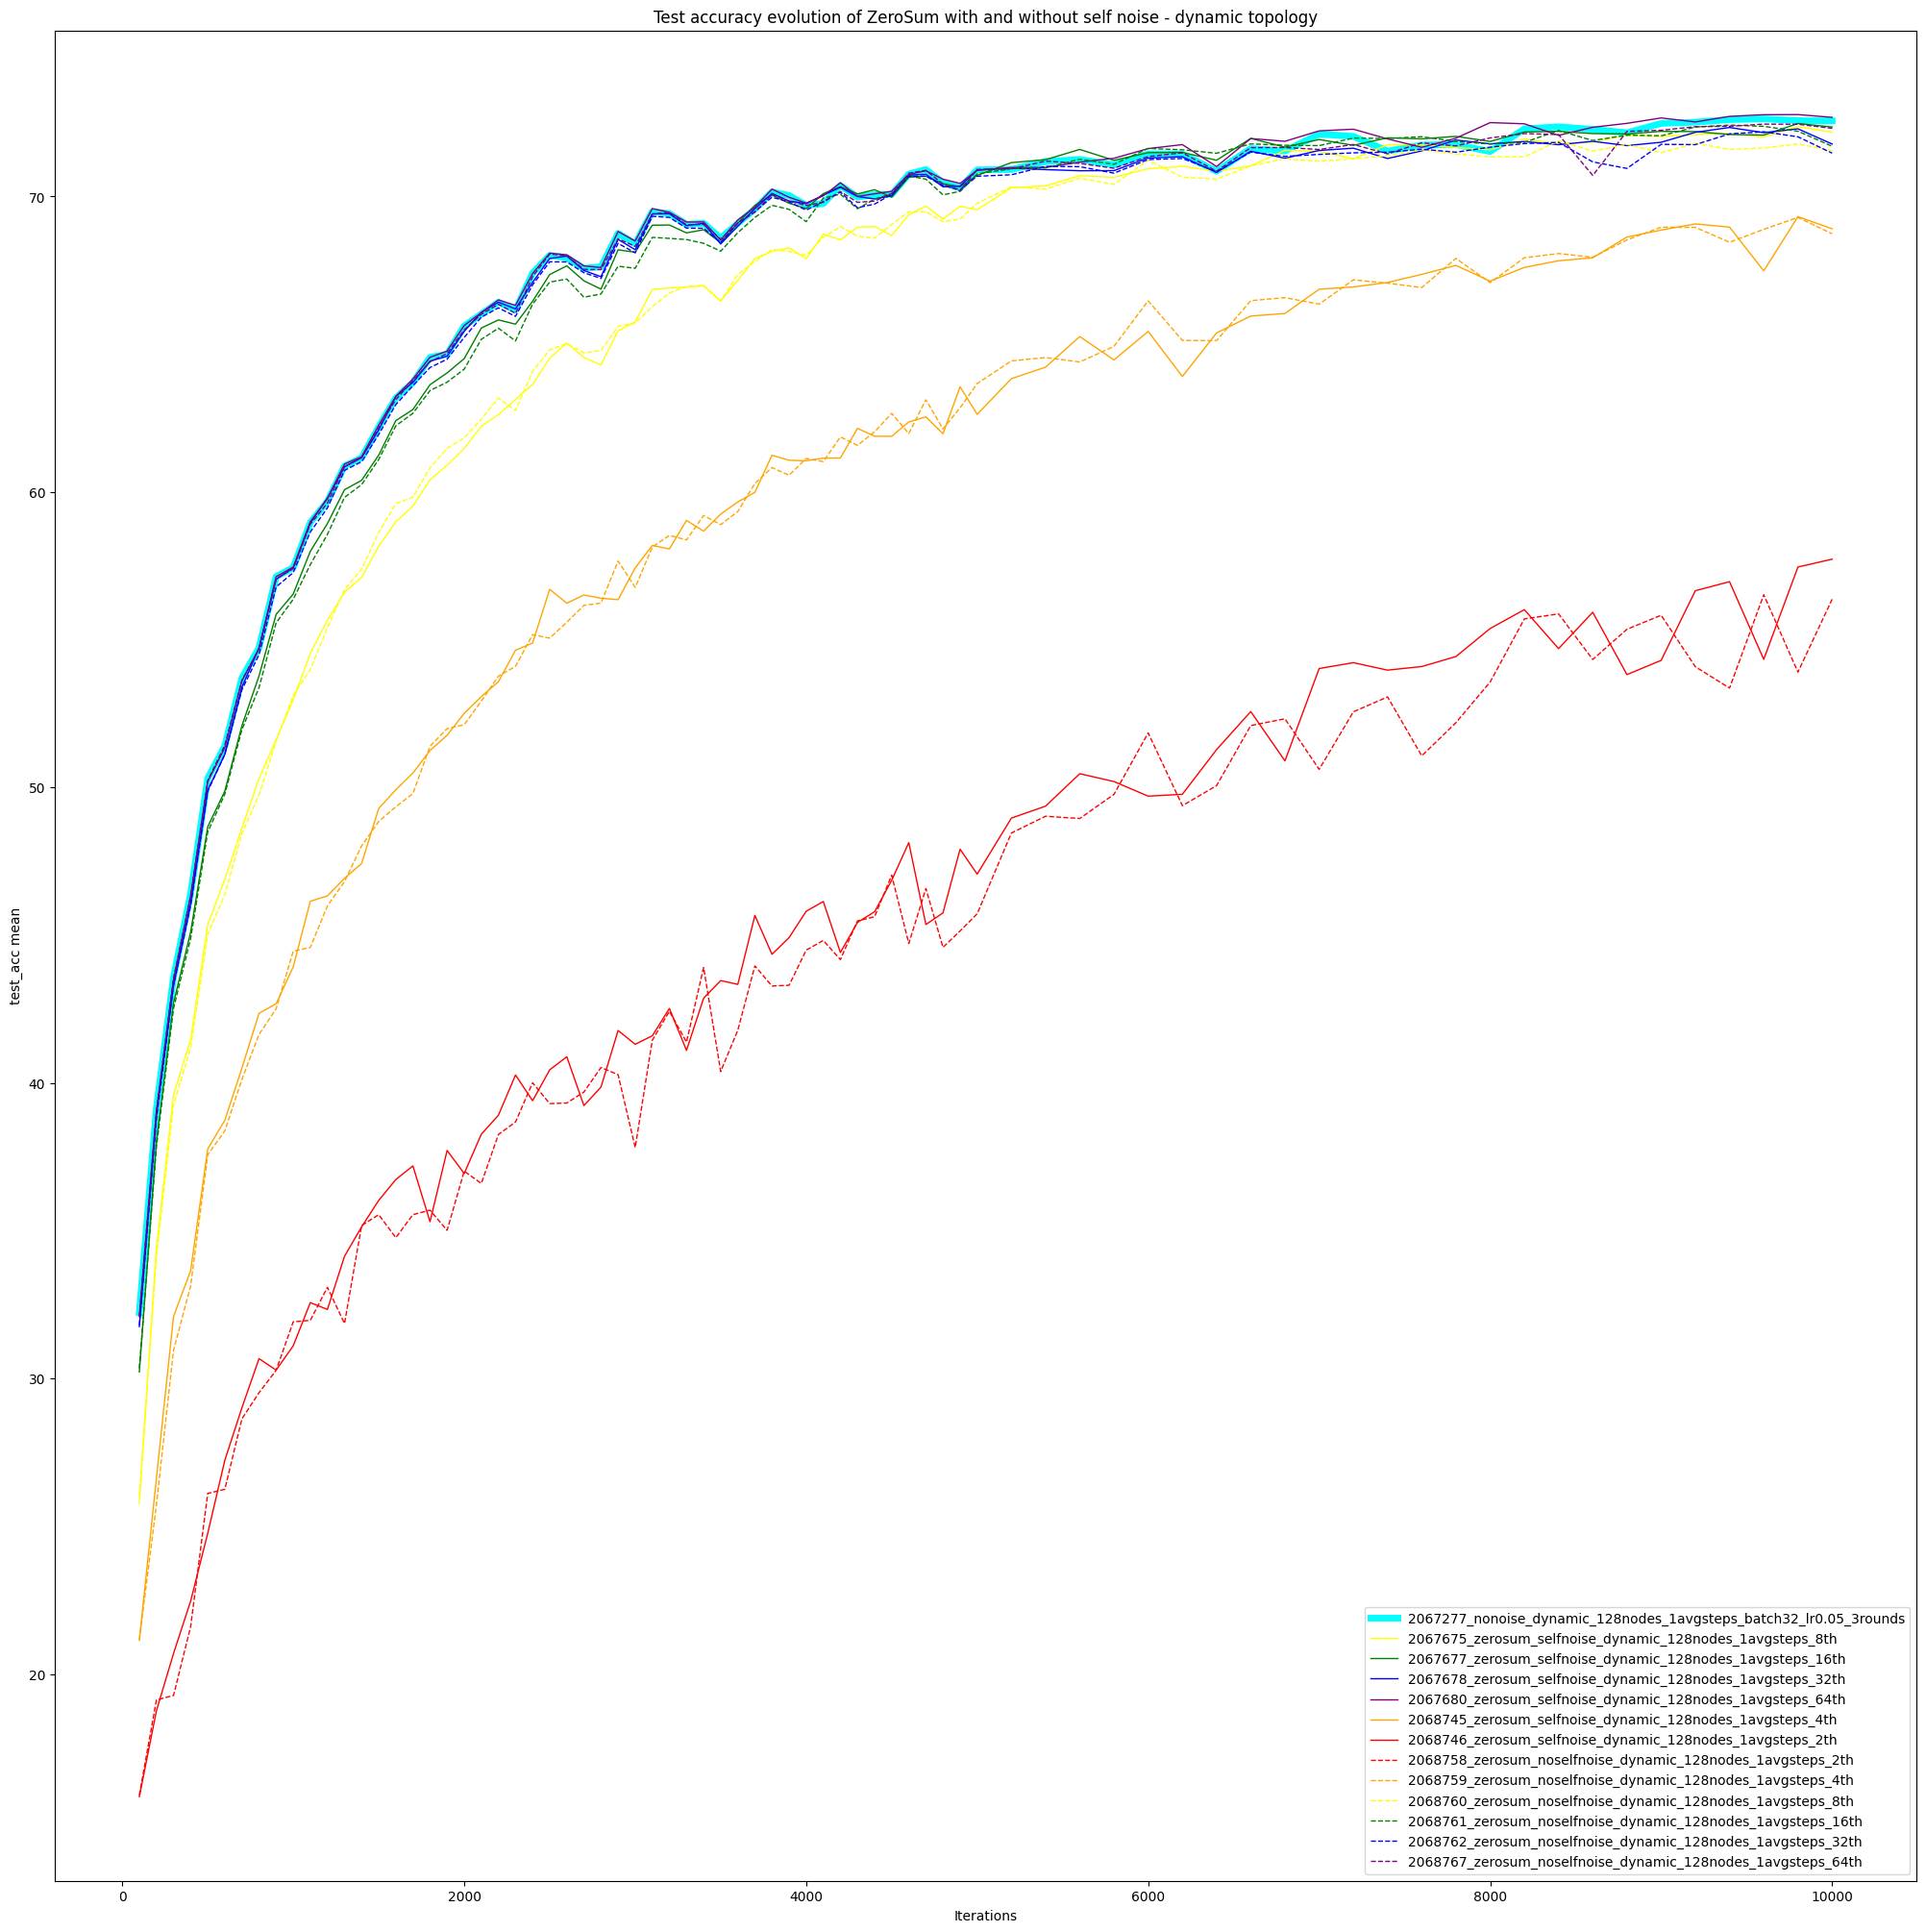

In [8]:
importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "noselfnoise":"--",
        "selfnoise":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Test accuracy evolution of ZeroSum with and without self noise - dynamic topology",
    "test_acc mean",
    save_directory=save_directory
    
)

# Attack results
## In the static case:

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2068748_zerosum_noselfnoise_static_128nodes_1avgsteps_2th
2068753_zerosum_noselfnoise_static_128nodes_1avgsteps_4th
2068754_zerosum_noselfnoise_static_128nodes_1avgsteps_8th
2068755_zerosum_noselfnoise_static_128nodes_1avgsteps_16th
2068756_zerosum_noselfnoise_static_128nodes_1avgsteps_32th
2068757_zerosum_noselfnoise_static_128nodes_1avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'tes

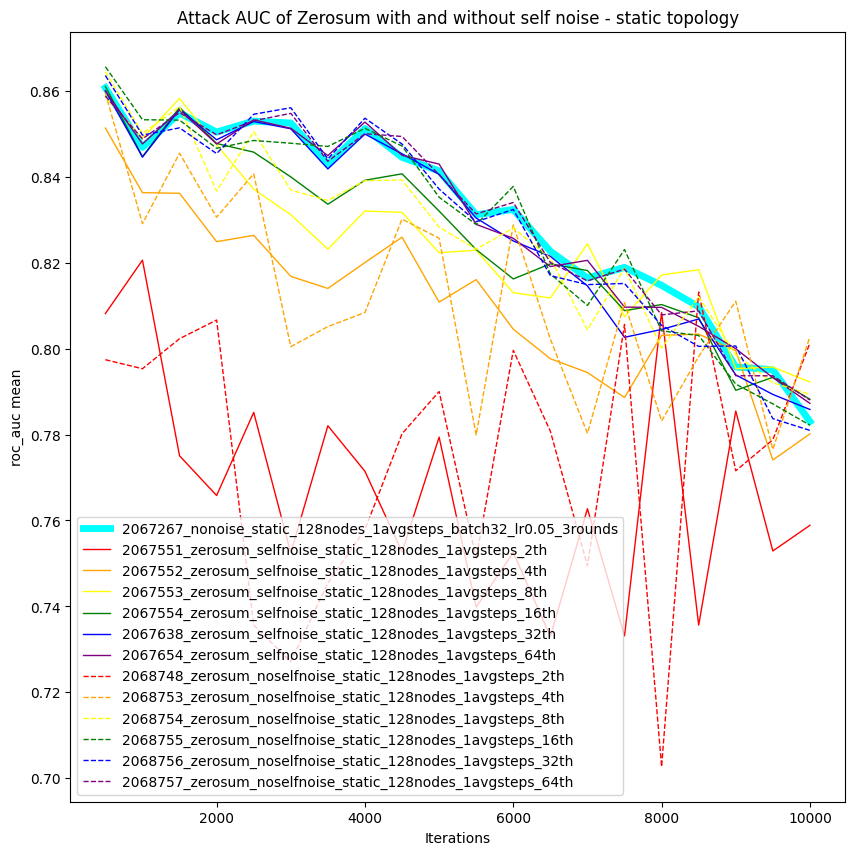

In [9]:
importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "noselfnoise":"--",
        "selfnoise":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Attack AUC of Zerosum with and without self noise - static topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

## Attack results in the dynamic case

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2068758_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_2th
2068759_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_4th
2068760_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_8th
2068761_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_16th
2068762_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_32th
2068767_zerosum_noselfnoise_dynamic_128nodes_1avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max'

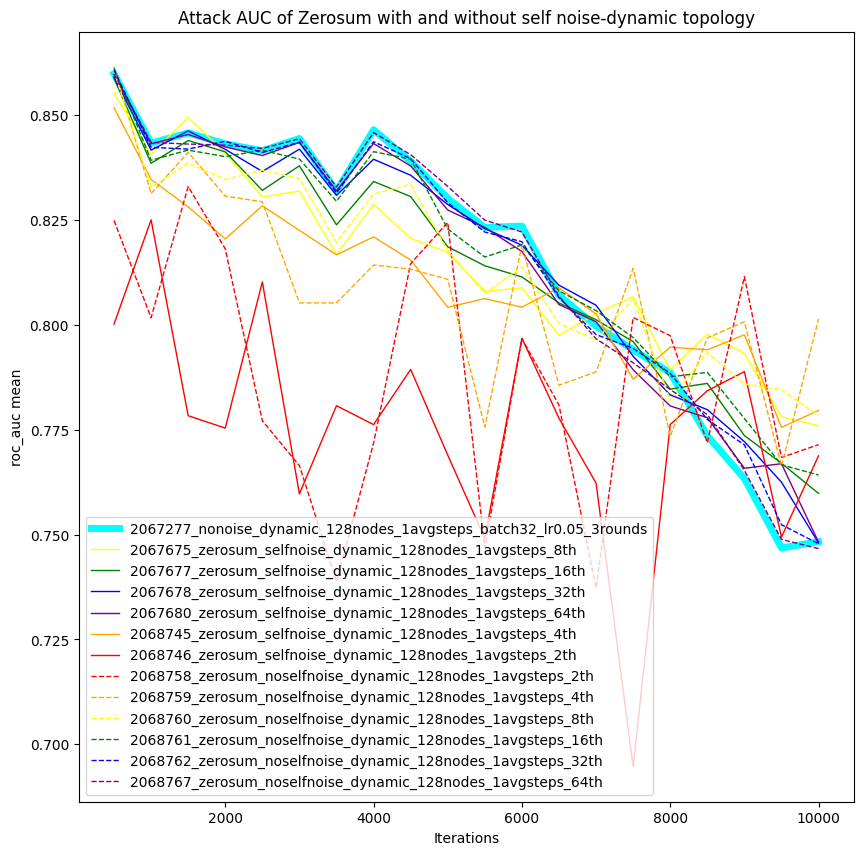

In [10]:
importlib.reload(utils)
zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "noselfnoise":"--",
        "selfnoise":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Attack AUC of Zerosum with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize= (10,10)
)

# Results vs Muffliato

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc

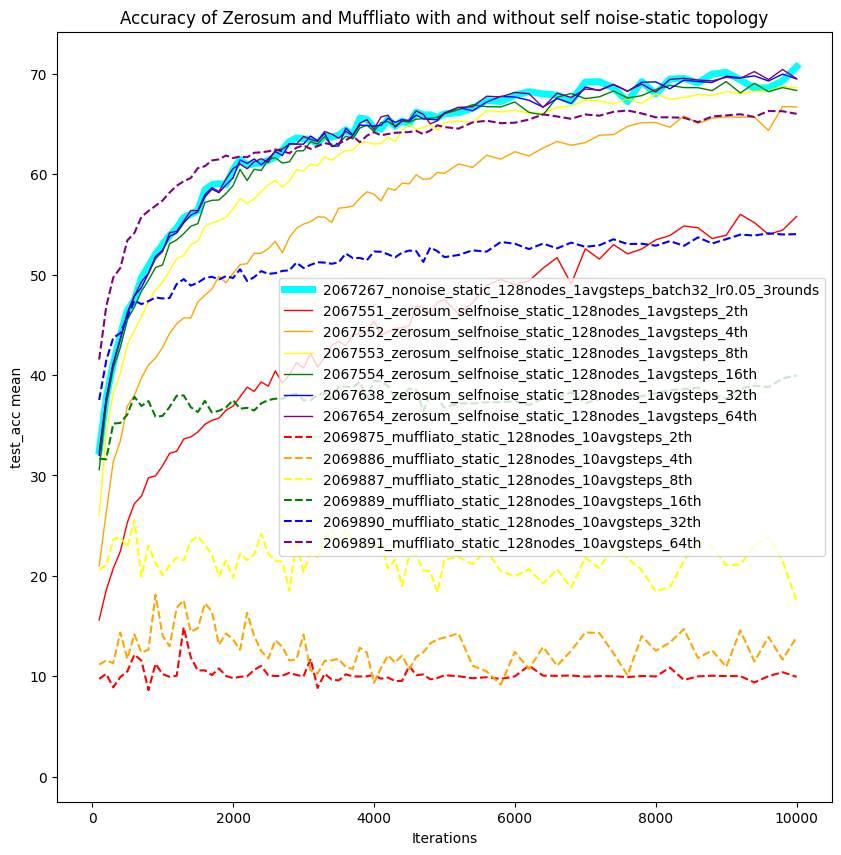

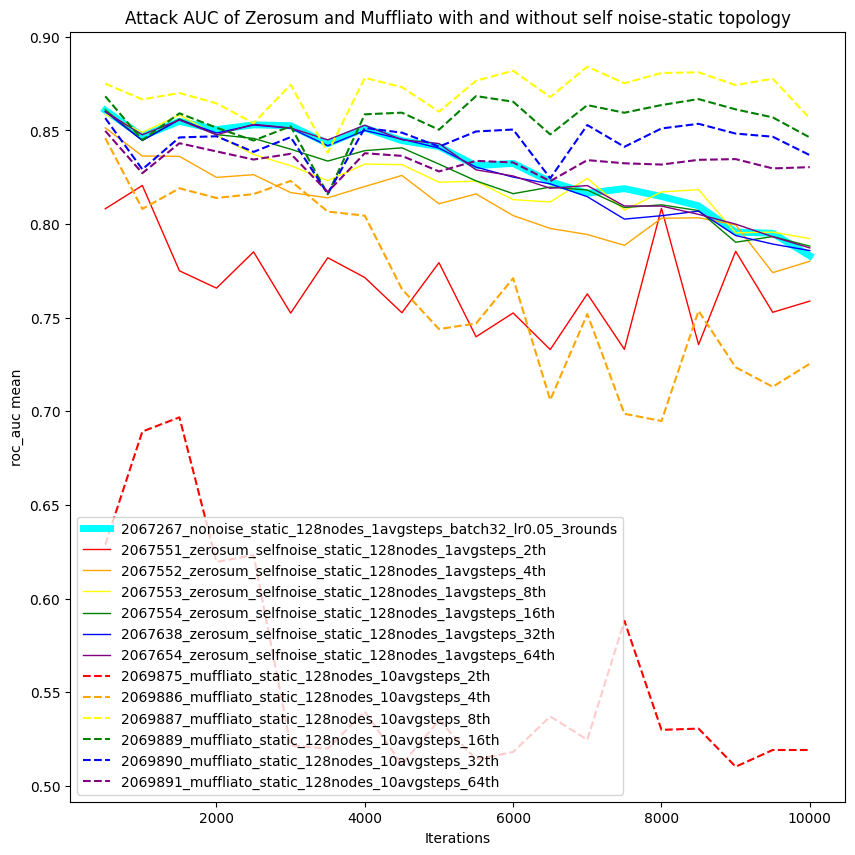

In [11]:
importlib.reload(utils)

zerosum_attributes = {
    "variant":["zerosum","nonoise"],
    "topology_type":["static"],
    # "avgsteps": ["1avgsteps","10avgsteps"],
    "avgsteps": ["1avgsteps"],
    "additional_attribute": [None,"selfnoise"]}
muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps":["10avgsteps"],
}

current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Accuracy of Zerosum and Muffliato with and without self noise-static topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.plot(1)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Attack AUC of Zerosum and Muffliato with and without self noise-static topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
2069896_muffliato_dynamic_128nodes_10avgsteps_8th
2069897_muffliato_dynamic_128nodes_10avgsteps_16th
2069898_muffliato_dynamic_128nodes_10avgsteps_32th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc su

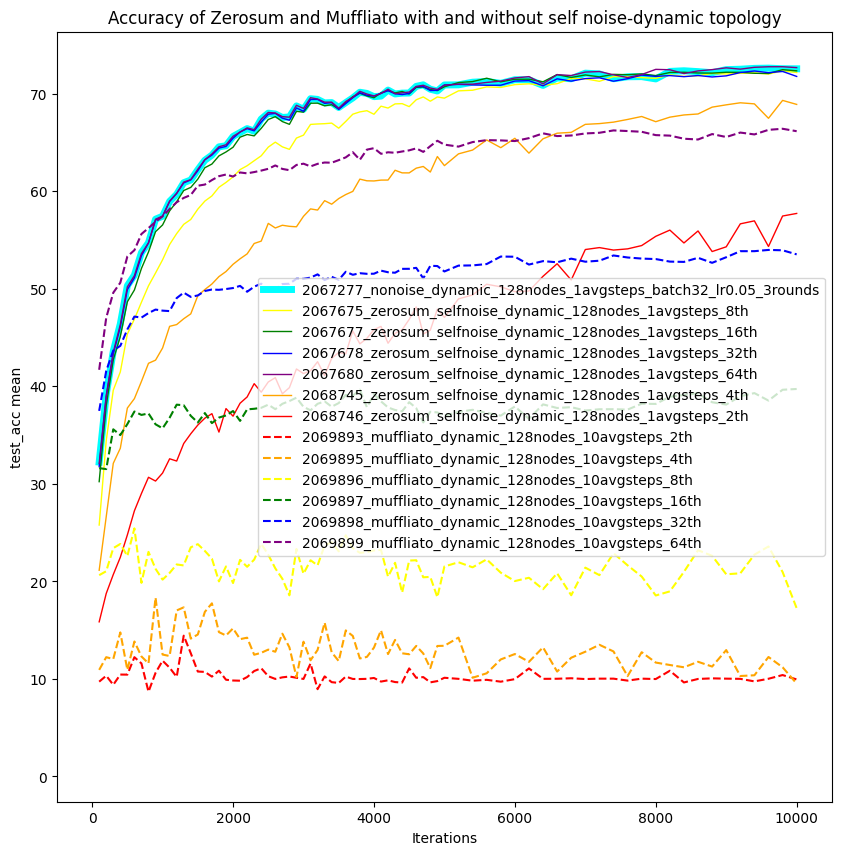

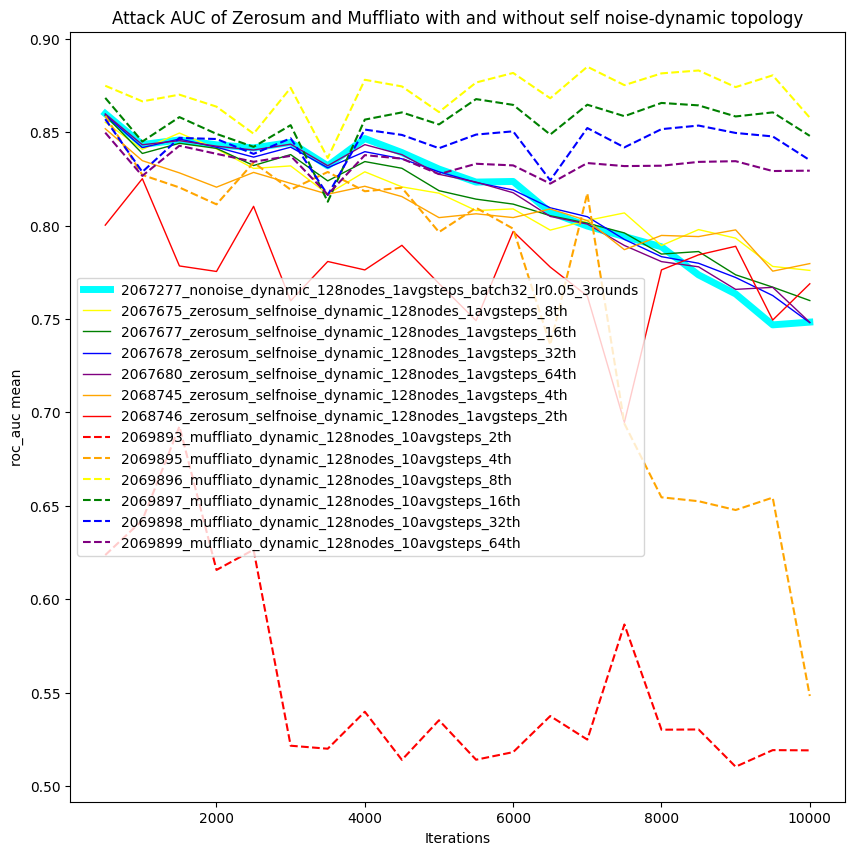

In [12]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"],
}
current_attributes=[zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(1)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Attack AUC of Zerosum and Muffliato with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

### Smaller plots to have an easier time to read the information

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'r

(0.7411661270362366, 1.0)

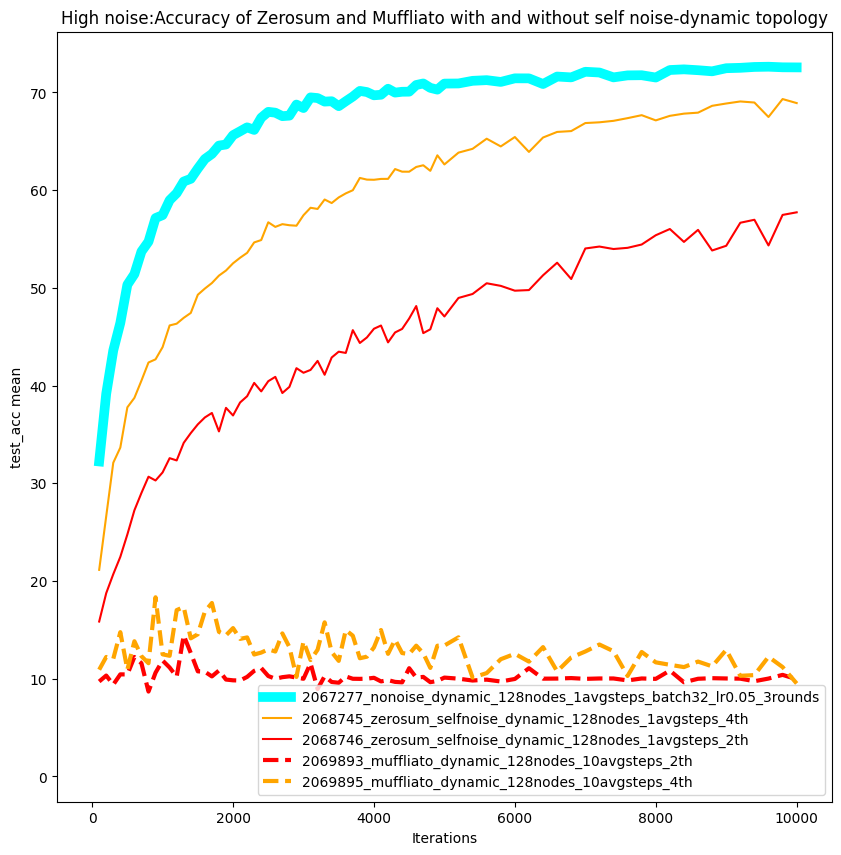

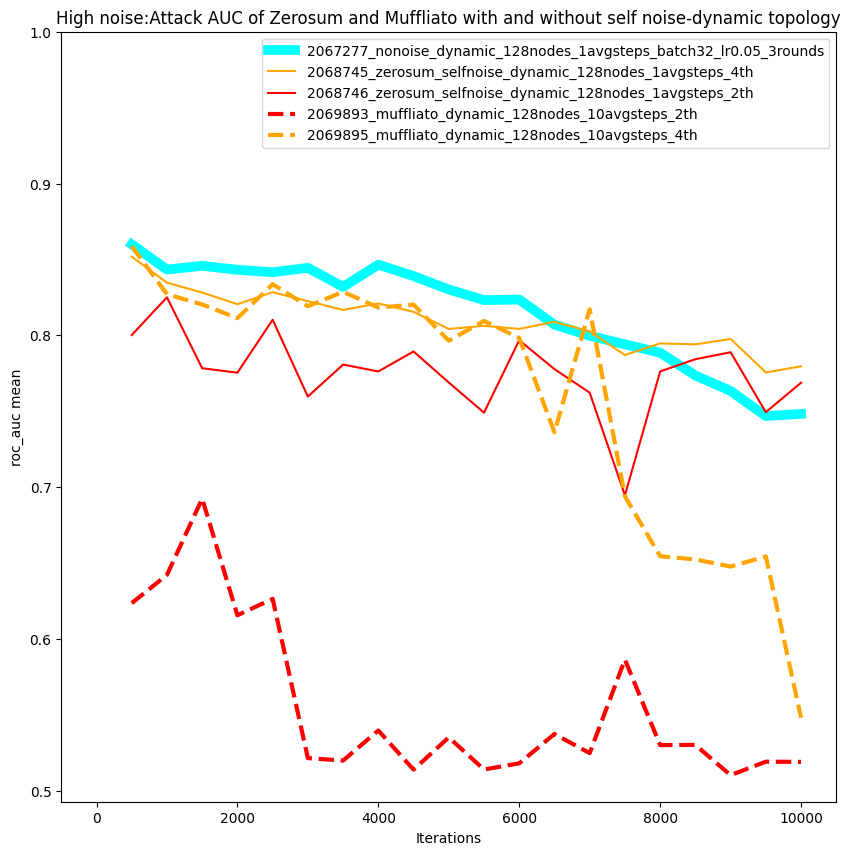

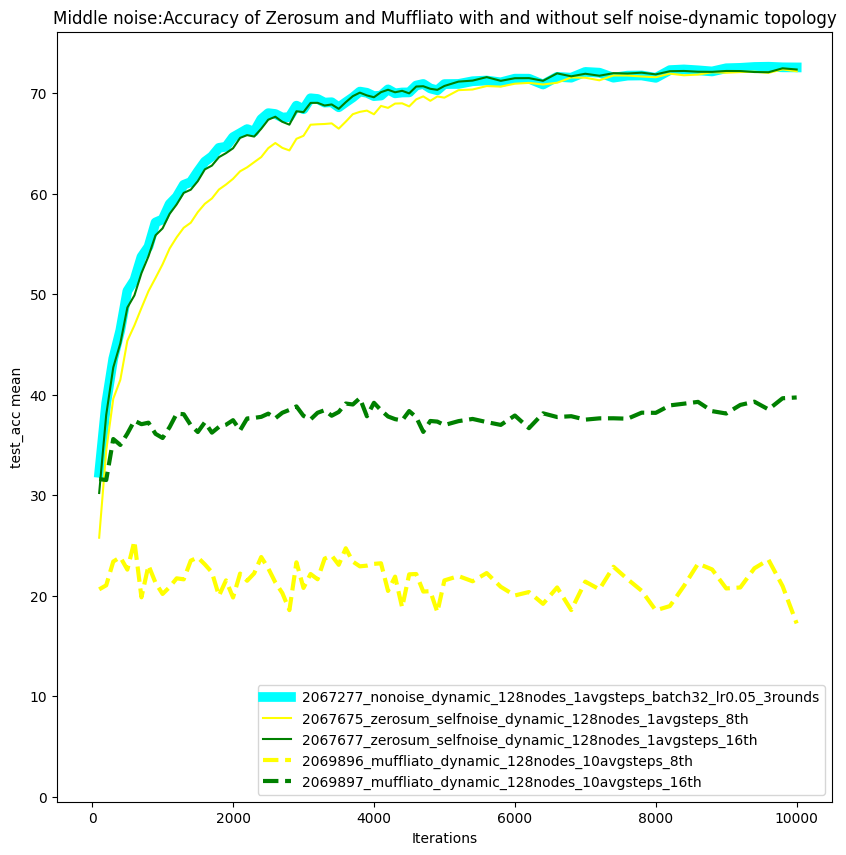

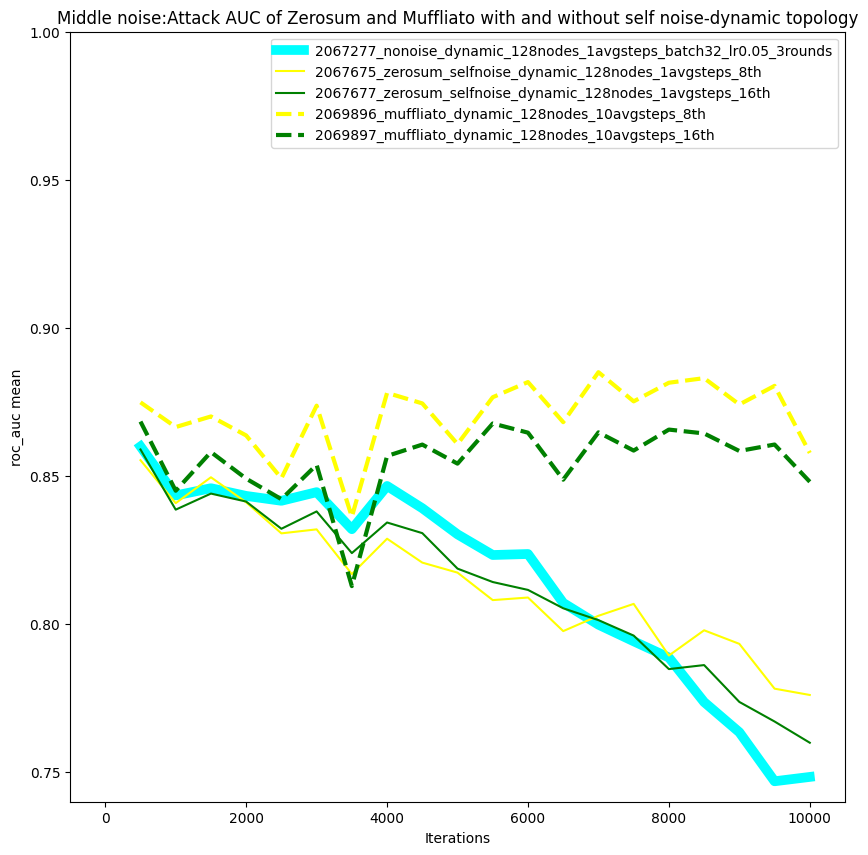

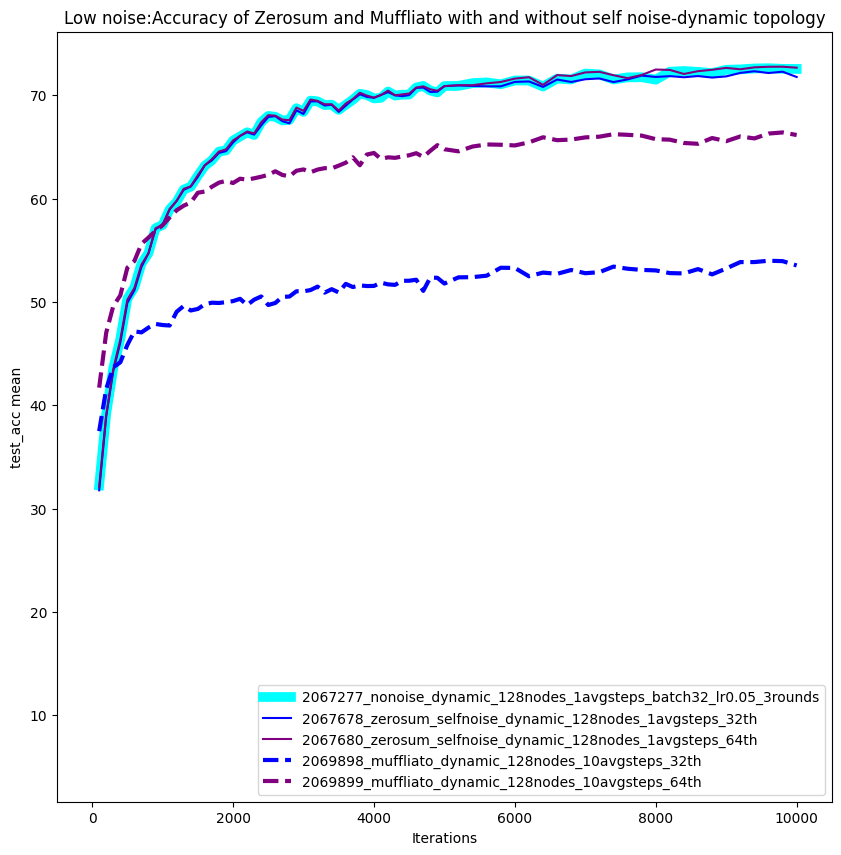

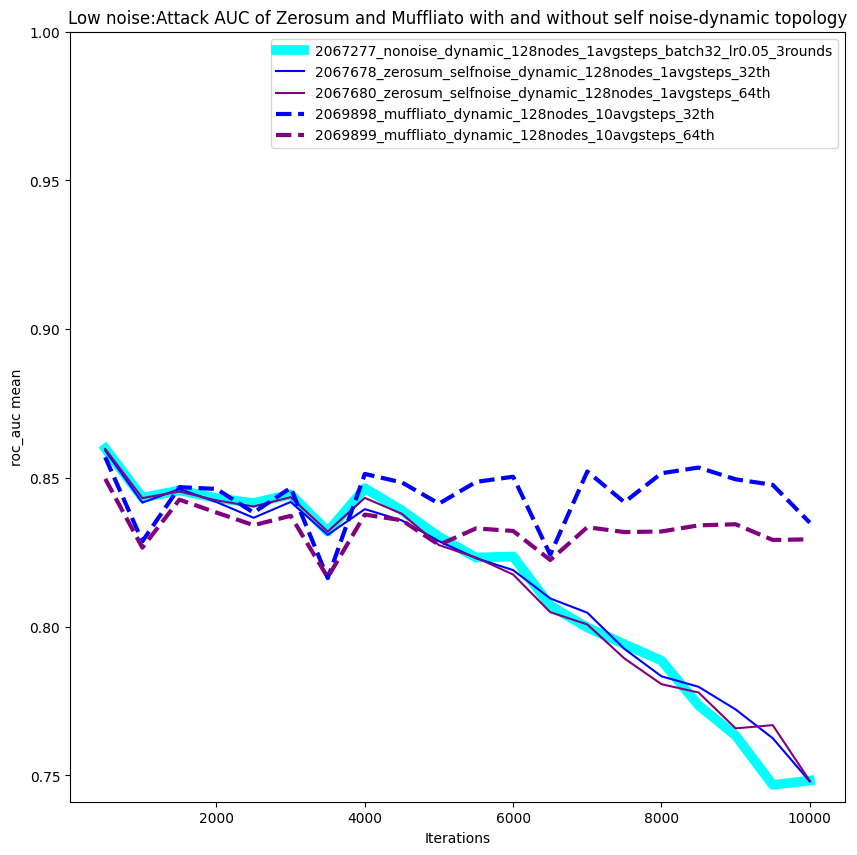

In [13]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":[None,"2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":7,
        "10avgsteps":3,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(1)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "High noise:Attack AUC of Zerosum and Muffliato with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)

# Plot the middle noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.plot(2)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(3)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Middle noise:Attack AUC of Zerosum and Muffliato with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)

# Plot the low noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"32th","64th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.plot(4)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(5)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Low noise:Attack AUC of Zerosum and Muffliato with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)



# Trying out scatterplots

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
----------------------------------------
Saving to assets/High_noises:Accuracy_vs_AUC.pdf
2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
----------------------------------------
Saving to assets/Middle_noises:Accuracy_vs_AUC.pdf
2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10a

(0.5, 1.0)

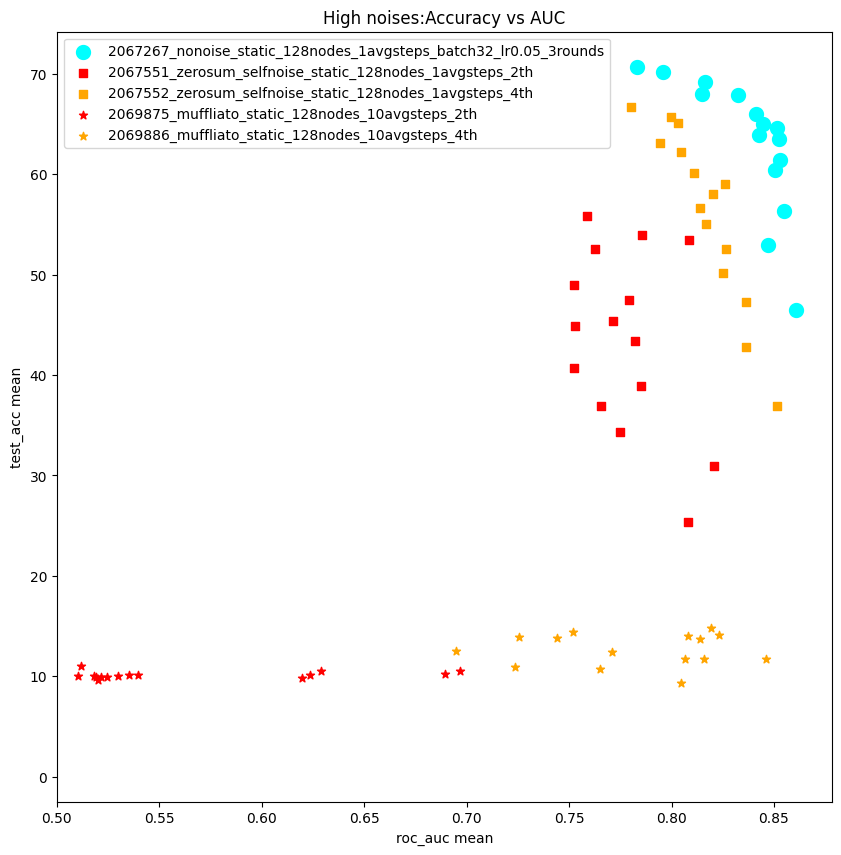

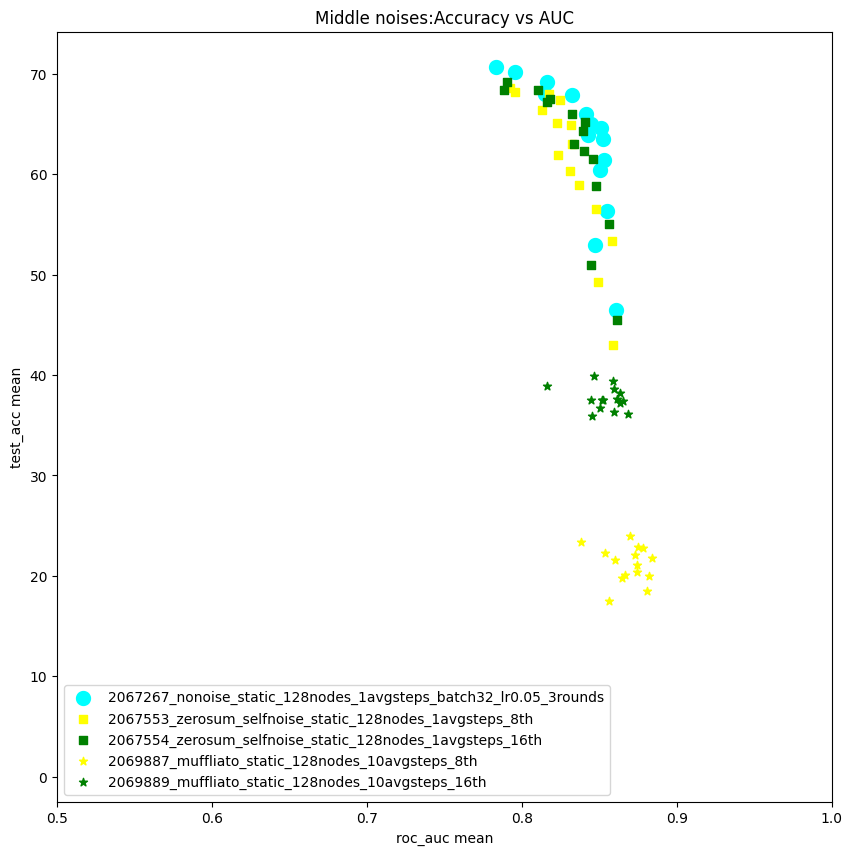

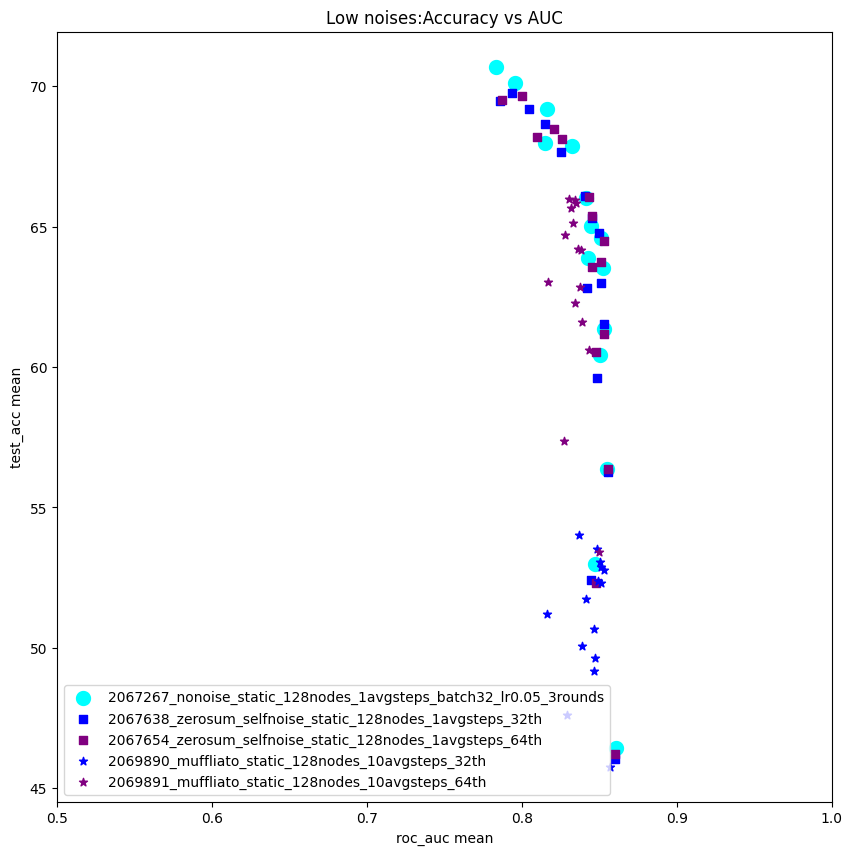

In [32]:
importlib.reload(utils)

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
    "noise_level":["2th","4th"]
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "marker":{
        "muffliato":"*",
        "zerosum":"s"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "High noises:Accuracy vs AUC",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.xlim(left=0.5,right=1)

# Plot the middle noises
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"16th","8th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
    "noise_level":["16th","8th"]
}
current_attributes = [zerosum_attributes,muffliato_attributes]

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


plt.plot(1)
utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Middle noises:Accuracy vs AUC",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.xlim(left=0.5,right=1)


# Plot the low noises
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"32th","64th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
    "noise_level":["32th","64th"]
}
current_attributes = [zerosum_attributes,muffliato_attributes]

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)

plt.plot(1)
utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Low noises:Accuracy vs AUC",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.xlim(left=0.5,right=1)

## Aggregated plots:

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10avgsteps_64th
Saving to assets/Accuracy_vs_AUC_evolution_accross_entire_runs.pdf


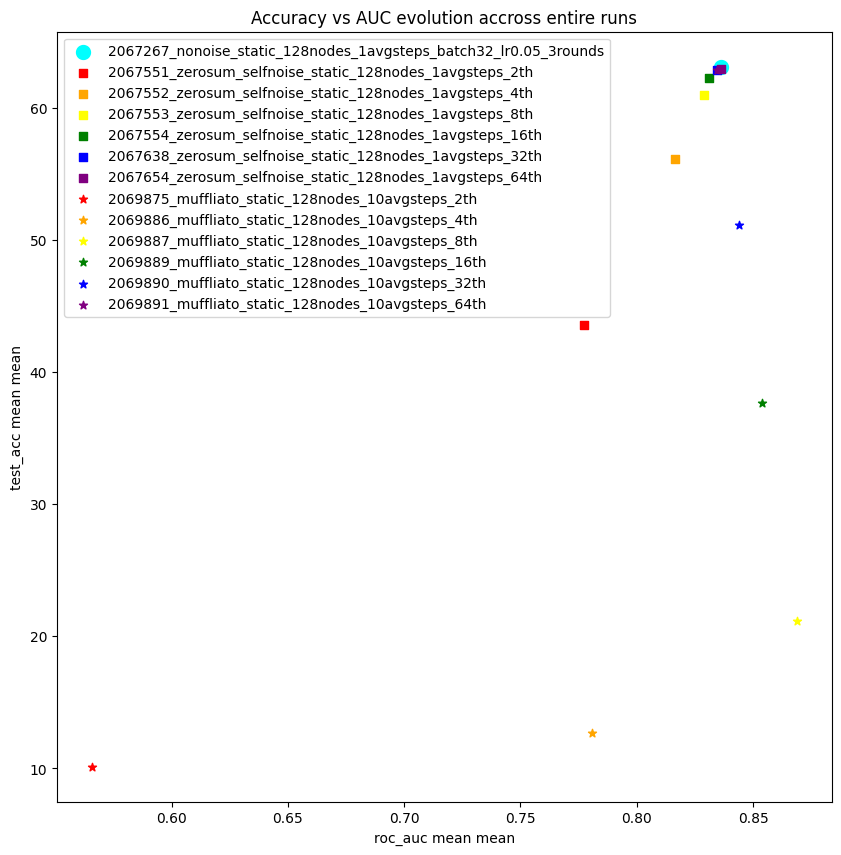

In [15]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "marker":{
        "muffliato":"*",
        "zerosum":"s"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs",
    "test_acc mean",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds


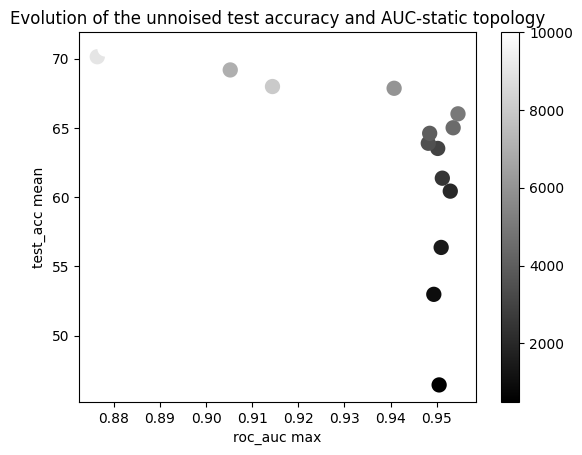

In [16]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None],
    # "noise_level":[None,"2th","4th"]
}

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "marker":{
        "muffliato":"*",
        "zerosum":"s"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


experiment = zerosum_experiments[0]
experiment_data = formatted_data[experiment] 

utils.scatter_evolution_iterations(
    experiment_data,
    zerosum_experiments[0],
    "test_acc mean",
    "roc_auc max",
    experiments_attributes[experiment],
    display_attributes,
    color_map_iteration=True
    # save_directory=save_directory,
    # figsize=(10,10)
)
title = "Evolution of the unnoised test accuracy and AUC-static topology"
plt.colorbar()
plt.xlabel("roc_auc max")
plt.ylabel("test_acc mean")
plt.title(title)
plt.savefig(save_directory + title.replace(" ","_") +".pdf")

## Better experiment display (selected noises levels)

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'roc_auc min',
       'roc_auc max', 'linkability_top1 count_percentage_success',
       'linkability_real_r

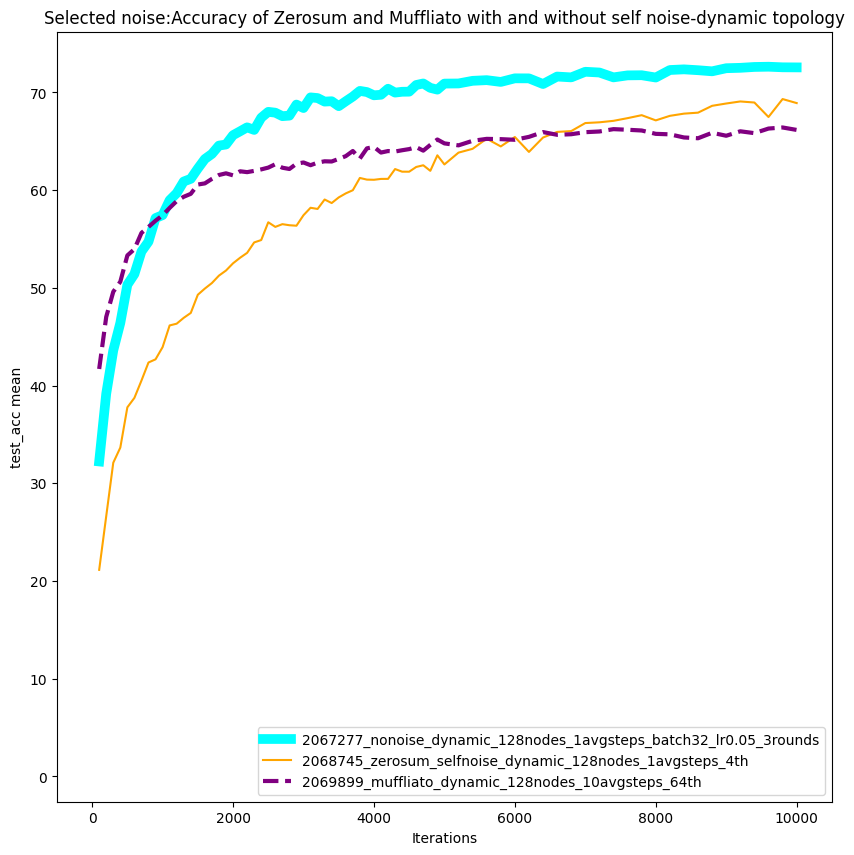

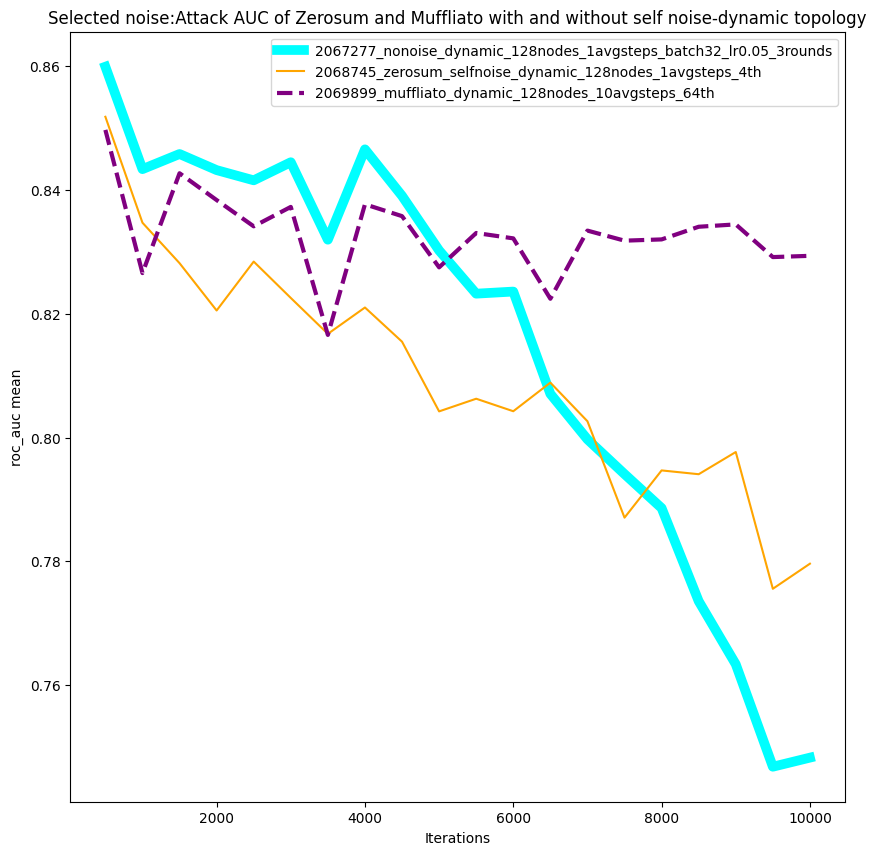

In [17]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":[None,"64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":7,
        "10avgsteps":3,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Selected noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(1)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Selected noise:Attack AUC of Zerosum and Muffliato with and without self noise-dynamic topology",
    "roc_auc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

## Plotting Linkability attack results

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'roc_auc min',
       'roc_auc max', 'linkability_top1 count_percentage_success',
       'linkability_real_r

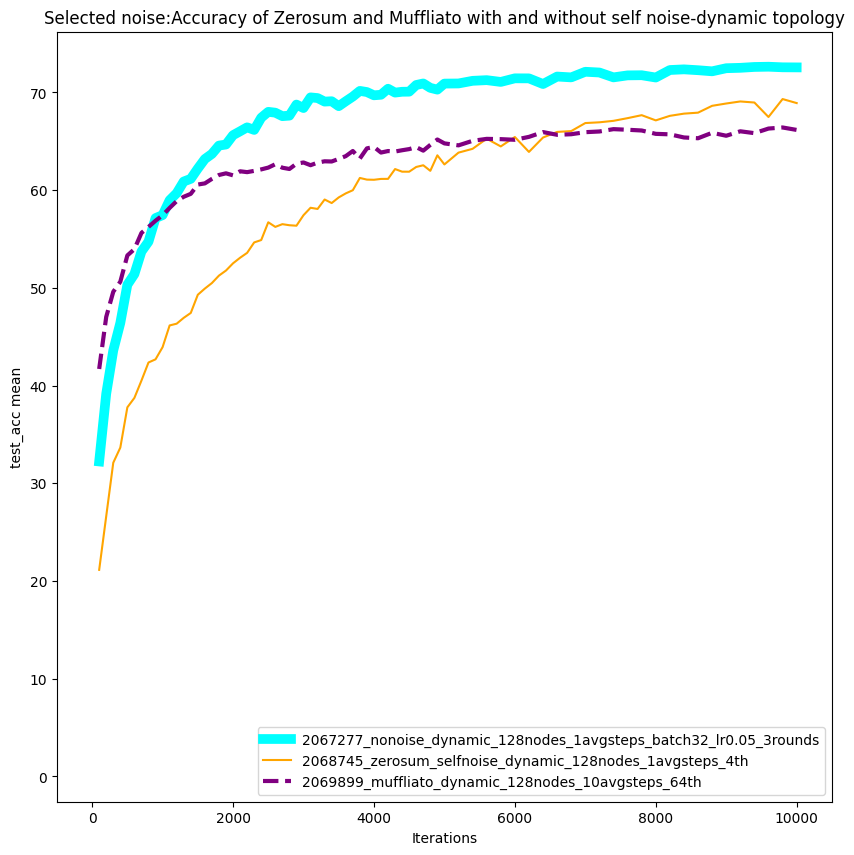

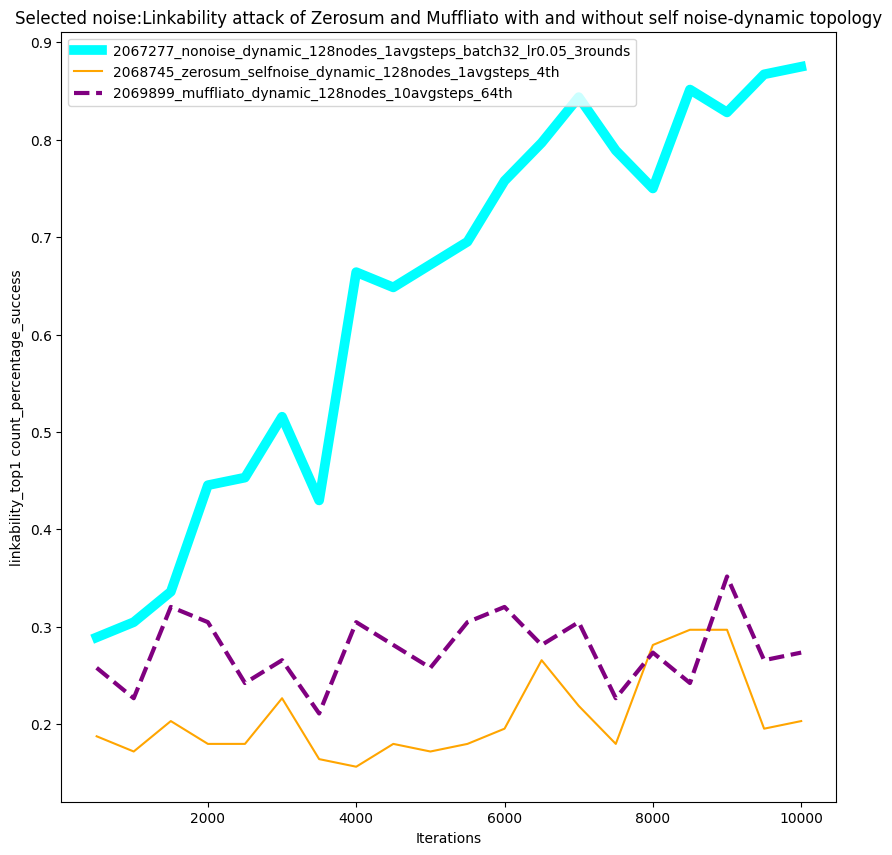

In [18]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":[None,"64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":7,
        "10avgsteps":3,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Selected noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(1)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Selected noise:Linkability attack of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    figsize=(10,10)
)

2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max', 'test_loss mean',
       'test_loss std', 'test_loss sum', 'test_loss min', 'test_loss max',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'total_bytes mean', 'total_bytes std',
       'total_bytes sum', 'total_bytes min', 'total_bytes max',
       'total_meta mean', 'total_meta std', 'total_meta sum', 'total_meta min',
       'total_meta max', 'total_data_per_n mean', 'total_data_per_n std',
       'total_data_per_n sum', 'total_data_per_n min', 'total_data_per_n max',
       'roc_auc mean', 'roc_auc std', 'roc_auc sum', 'r

(0.095703125, 1.0)

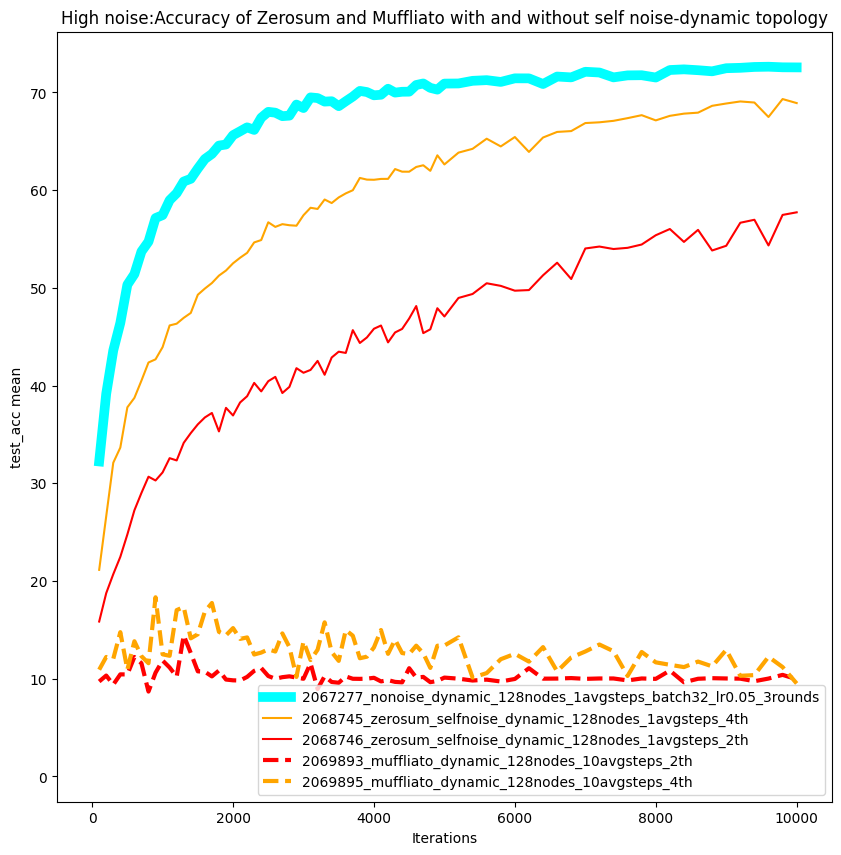

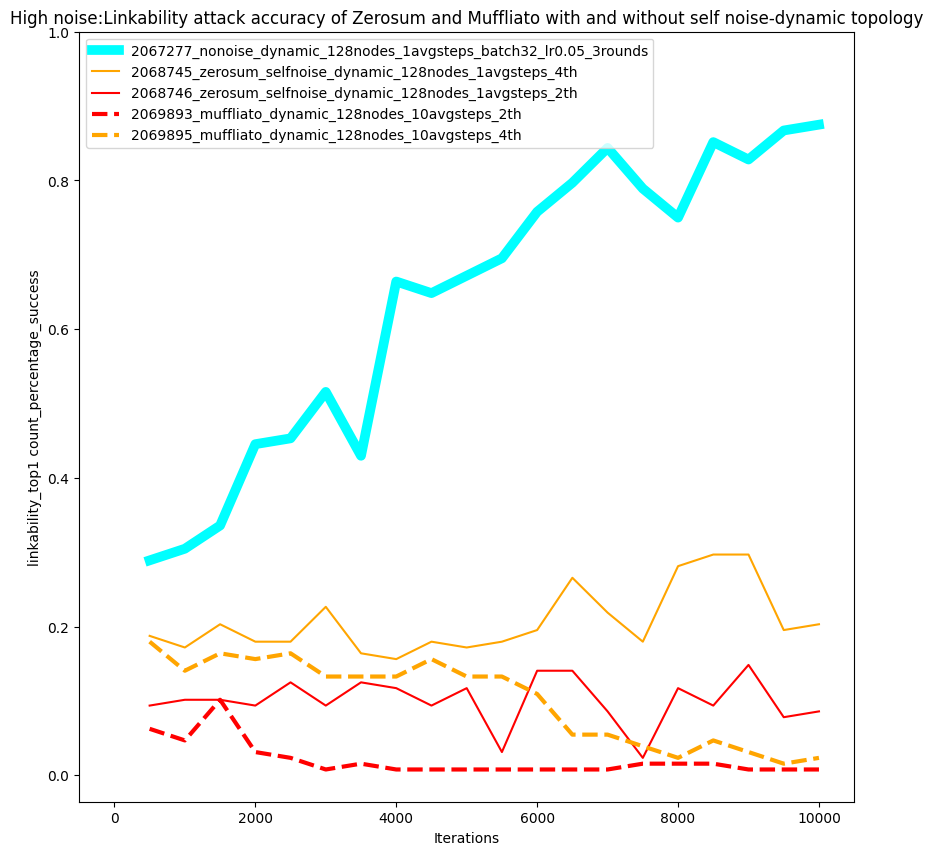

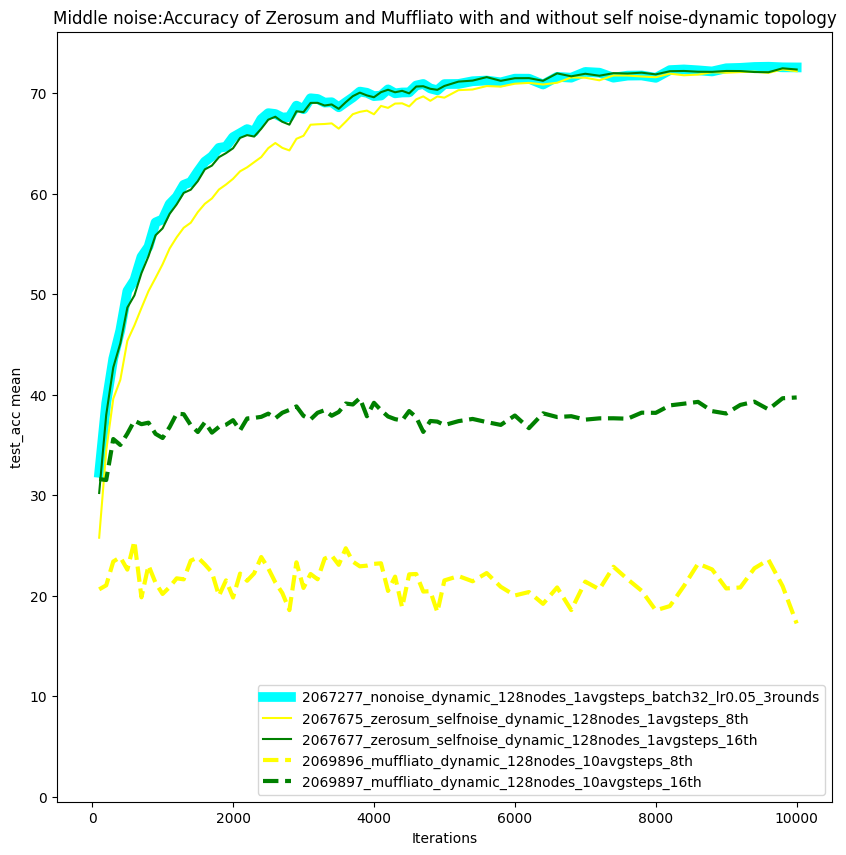

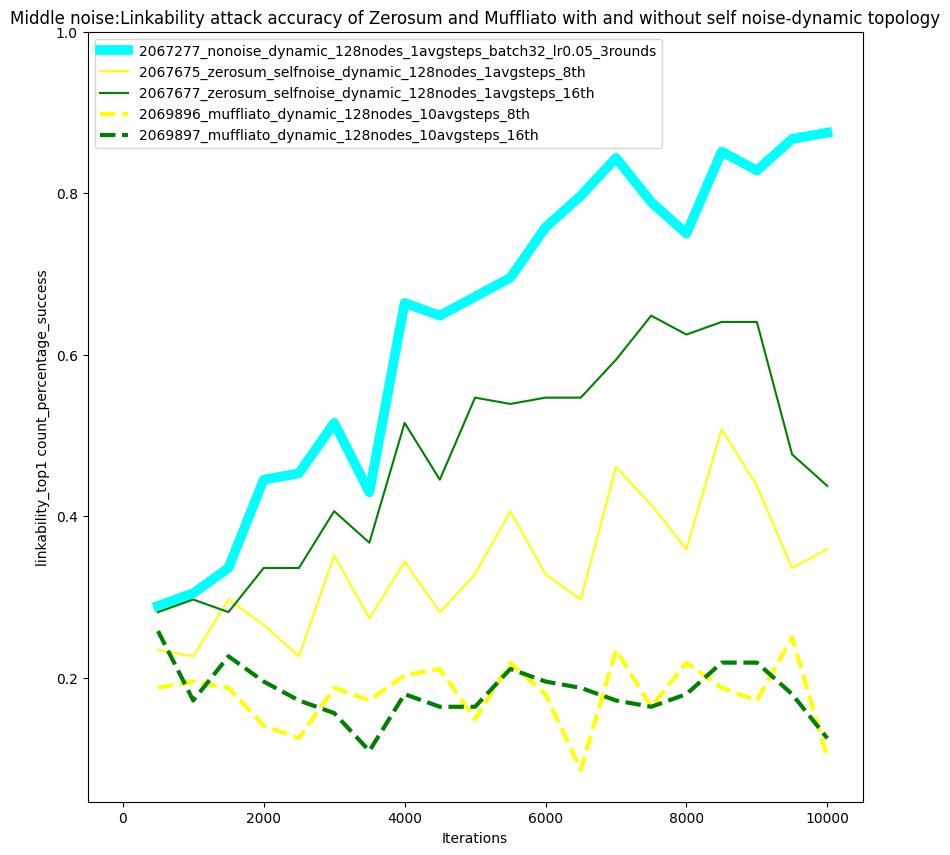

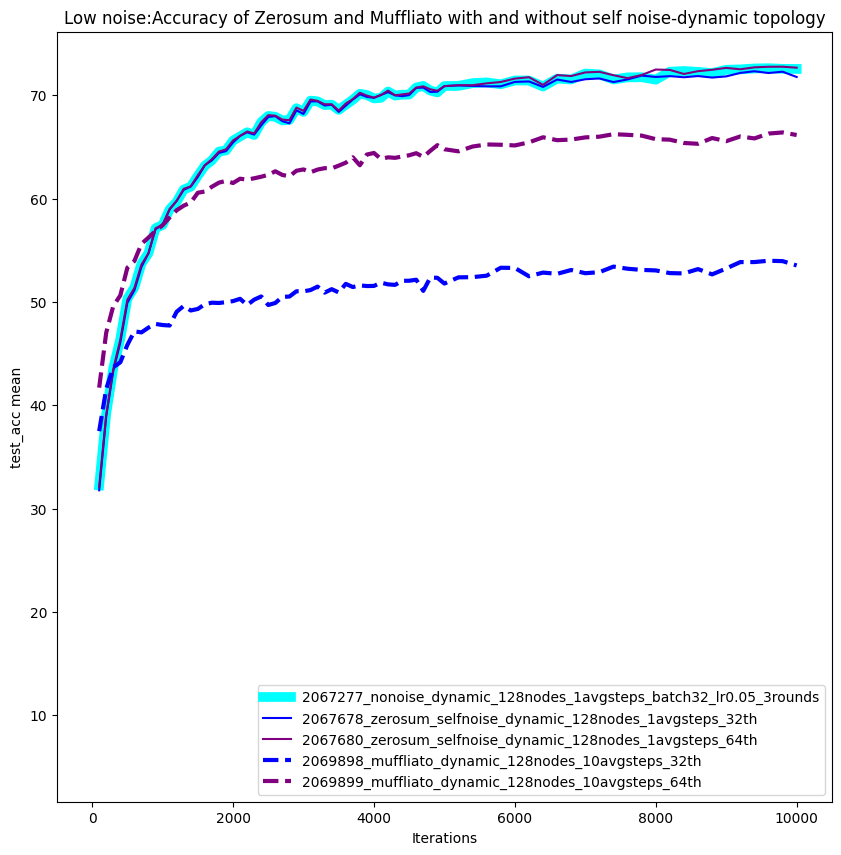

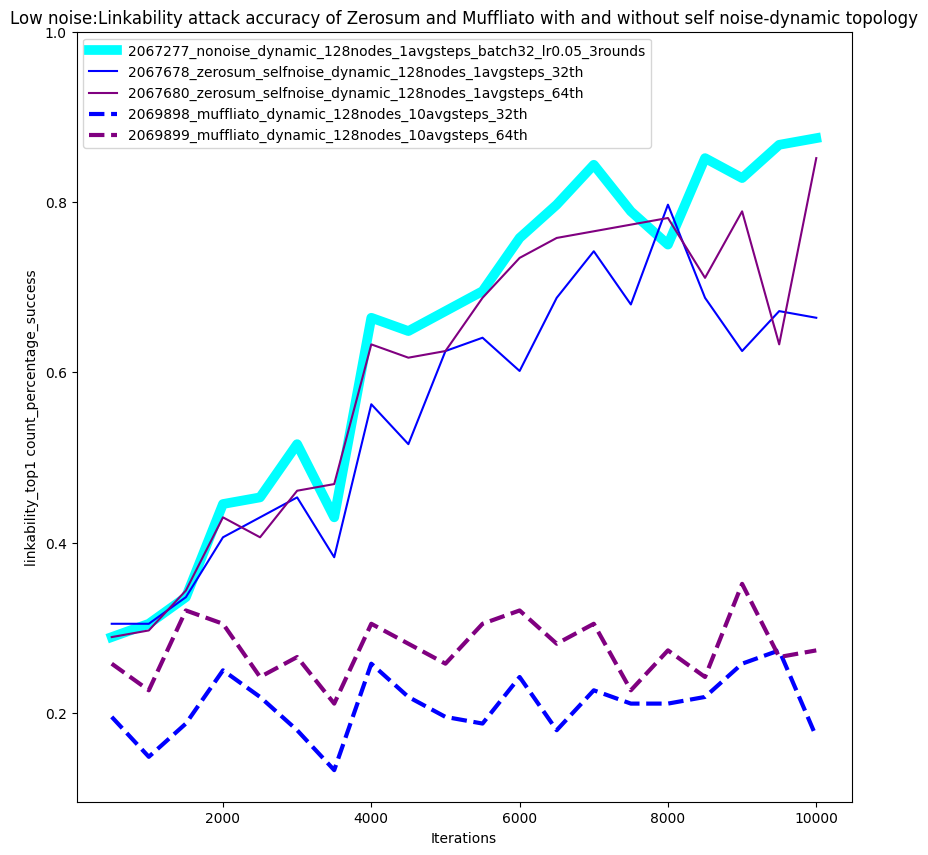

In [19]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":[None,"2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "linestyle":{
        "muffliato":"--",
        "zerosum":"-"
    },
    "linewidth":{
        "nonoise":7,
        "10avgsteps":3,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(1)

utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "High noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)

# Plot the middle noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.plot(2)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(3)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Middle noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)

# Plot the low noises
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
    "noise_level":[None,"32th","64th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.plot(4)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    figsize=(10,10)
)

plt.plot(5)
utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Low noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    figsize=(10,10)
)
plt.ylim(top=1)



## Linkability attack: aggregated plots

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10avgsteps_16th
2069890_muffliato_static_128nodes_10avgsteps_32th
2069891_muffliato_static_128nodes_10avgsteps_64th
Saving to assets/Accuracy_vs_Linkability_attack_success_rate_evolution_accross_entire_runs.pdf


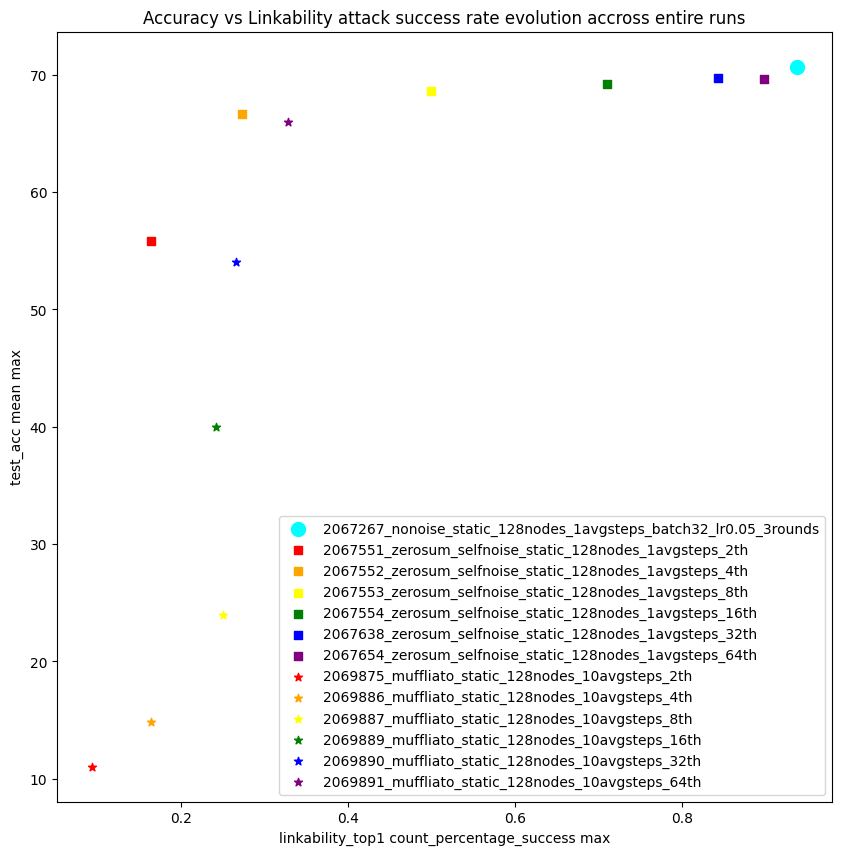

In [20]:
importlib.reload(utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": [None,"selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"],
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes ={
    "color":{
        "nonoise":"cyan",
        "2th":"red",
        "4th":"orange",
        "8th": "yellow",
        "16th":"green",
        "32th":"blue",
        "64th":"purple",
    },
    "marker":{
        "muffliato":"*",
        "zerosum":"s"
    },
    "linewidth":{
        "nonoise":5,
        "zerosum":1,
    }
}

zerosum_experiments = utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    experiments_attributes,
    display_attributes,
    "Accuracy vs Linkability attack success rate evolution accross entire runs",
    "test_acc mean",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    figsize=(10,10),
    method="max",
)